## Calculate Grit for Bulk Cell Health profiles

Here, we calculate grit in several permutations

1. Across the three different cell lines (A549, ES2, HCC44)
2. Using two different kinds of controls (cutting and permutation)
3. Using two different correlation metrics (Pearson and Spearman)
4. Using two different metrics to summarize control-based z-scored replicate correlations (mean and median)

We also calculate mp-value for the same perturbations.

In [1]:
import pathlib
from functools import partial

import numpy as np
import pandas as pd

from pycytominer.cyto_utils import infer_cp_features, output
from pycytominer import feature_select, aggregate

from cytominer_eval import evaluate_metrics
from cytominer_eval.transform import metric_melt
# from cytominer_eval.operations.util import assign_replicates

import plotnine as gg
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, MultipleLocator

plt.rcParams["font.family"] = ["Open Sans"]
plt.rcParams["font.size"] = 16

In [2]:
def calc_map(df, pair_config, map_config):
    meta_features = df.filter(regex="Metadata_").columns.tolist()
    features = df.filter(regex="^(?!Metadata)").columns.tolist()
    
    map_results = []

    results = evaluate_metrics(
        profiles=df.reset_index(drop=True),
        features=features,
        meta_features=meta_features,
        replicate_groups=pair_config,
        metrics_config=map_config,
        use_copairs=True,
    )

    map_result = results["mean_ap"]
    map_results.append(map_result)

    map_results = pd.concat(map_results).reset_index(drop=True)
    map_results["-log10(mAP p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
    # map_results["p < 0.05"] = map_results["p_value"].apply(lambda x: "$\it{p}$ < 0.05" if x < 0.05 else "$\it{p}$ >= 0.05")
    map_results["p < 0.05"] = map_results["p_value"] < 0.05
    map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)
    print(map_results.shape)
    return map_results

In [3]:
def x_axis_formatter(x, pos, n_labels=5):
    if pos == 1 or pos == n_labels - 1:
        return f'{int(x)}'  # Format the first tick label as '0' without decimals
    else:
        return f'{x:.2f}'  # Use general format for other labels

def remove_inner_ticklabels(fig: plt.Figure):
    """
    Remove inner ticklabels from a figure.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure to remove inner ticklabels from.
    """
    for ax in fig.axes:
        try:
            ax.label_outer()
        except AttributeError:
            pass

# # single map plot is a bit outdated, see up-to-date triple version below
# def plot_map(df, title, move_legend="lower right", pr_x = 0.8, pr_y = 0.3):
#     fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

#     mean_map = df['mAP'].mean()
#     # fr = (df['p < 0.05'] == "$\it{p}$ < 0.05").mean()
#     fr = df['p < 0.05'].mean()
#     # sns.scatterplot(
#     #     ax=axes[0], 
#     #     data=df, 
#     #     x='mAP', 
#     #     y='-log10(p-value)', 
#     #     hue='p < 0.05',
#     #     s=50
#     # )
#     sns.jointplot(ax=axes[0], data=df, x="mAP", y='-log10(p-value)', hue='p < 0.05')
#     # axes[0].set_title(title)
#     axes[0].text(pr_x, pr_y, f"Retrieved: {fr:.0%}", transform=axes[0].transAxes)

#     axes[0].set_xlabel("")
#     axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
    
#     # handles, labels = axes[0].get_legend_handles_labels()
#     # axes[0].legend(handles=handles, labels=labels)
#     sns.move_legend(axes[0], move_legend)

#     # Second Row: KDE plots
#     max_kde_y = 0
#     mean_map = df['mAP'].mean()
#     for p_value in sorted(df['p < 0.05'].unique()):
#         ax = sns.kdeplot(
#             ax=axes[1],
#             data=df[df['p < 0.05'] == p_value],
#             x='mAP', 
#             label=str(p_value)
#         )
#         max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
#         axes[1].axvline(mean_map, color='grey', linestyle='--')
#     axes[1].set_ylabel("")
#     axes[1].set_ylim(0, max_kde_y)
#     axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

#     for ax in axes.flat:
#         ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

#     remove_inner_ticklabels(fig)
#     plt.tight_layout()
#     plt.show()


# def plot_map_x3(df, variable, title, move_legend="lower right", pr_x=0.61, pr_y=0.35, s=50):
#     unique_values = df[variable].unique()
#     num_plots = len(unique_values)
    
#     # Create a row of subplots - each subplot has two rows for scatter and KDE plot
#     fig, axes = plt.subplots(2, num_plots, figsize=(4 * num_plots, 4), gridspec_kw={
#         'height_ratios': [5, 1],
#         'hspace': 0.05
#         })

#     for i, value in enumerate(unique_values):
#         sub_df = df[df[variable] == value]
#         mean_map = sub_df['mAP'].mean()
#         fr = sub_df['p < 0.05'].mean()

#         ax_scatter = axes[0, i]
#         sns.scatterplot(
#             ax=ax_scatter,
#             data=sub_df, 
#             x='mAP', 
#             y='-log10(mAP p-value)', 
#             hue='p < 0.05',
#             s=s
#         )
#         # g = sns.jointplot(ax=ax_scatter, data=df, x="mAP", y='-log10(mAP p-value)', hue='p < 0.05')
#         # g.ax_marg_x.remove()
#         #
#         #  ax_scatter.set_title(f"{title} - {value}")
#         if i == 1:
#             ax_scatter.text(pr_x, 0.02, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
#         else:
#             ax_scatter.text(pr_x, pr_y, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
#         # ax_scatter.text(pr_x, pr_y, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
        
#         # ax_scatter.set_xlabel("")
#         ax_scatter.get_xaxis().set_visible(False)
#         ax_scatter.set_ylim(-0.1, max(sub_df['-log10(mAP p-value)'])+0.3)
#         if i == num_plots - 1:
#             sns.move_legend(ax_scatter, "upper left", bbox_to_anchor=(1, 0.5), frameon=False)
#             # sns.move_legend(ax_scatter, move_legend, {"box_to_anchor": (1.05, 1)})
#         else:
#             ax_scatter.get_legend().remove()

#         ax_scatter.spines['top'].set_visible(False)
#         ax_scatter.spines['right'].set_visible(False)

        
#         # ax_scatter.legend(frameon=False)
#         # if i == 1:
#         #     sns.move_legend(ax_scatter, move_legend, frameon=False)

#         # KDE plot
#         ax_kde = axes[1, i]
#         max_kde_y = 0
#         for p_value in sorted(sub_df['p < 0.05'].unique()):
#             sns.kdeplot(
#                 ax=ax_kde,
#                 data=sub_df[sub_df['p < 0.05'] == p_value],
#                 x='mAP', 
#                 label=str(p_value)
#             )
#             max_kde_y = max(max_kde_y, max(ax_kde.lines[-1].get_ydata()))
#         ax_kde.axvline(mean_map, color='grey', linestyle='--')
#         ax_kde.set_ylim(0, max_kde_y)
#         if mean_map < 0.5:
#             ax_kde.text(mean_map + 0.01, 0.5, f"Mean mAP: {mean_map:.2f}", transform=ax_kde.transAxes)
#         else:
#             ax_kde.text(mean_map -0.3, 0.5, f"Mean mAP: {mean_map:.2f}", transform=ax_kde.transAxes)
#         ax_kde.set_xlim(0, 1)
#         ax_kde.set_xlabel("")
#         ax_kde.get_yaxis().set_visible(False)
#         ax_kde.get_xaxis().set_major_formatter(FuncFormatter(x_axis_formatter))

#         # Remove top and right spines for KDE plot
#         ax_kde.spines['top'].set_visible(False)
#         ax_kde.spines['right'].set_visible(False)
#         # ax_kde.spines['left'].set_visible(False)

#     fig.text(0.5, -0.01, "mAP", ha='center', va='center')

#     remove_inner_ticklabels(fig)
#     fig.subplots_adjust(hspace=0)
#     plt.tight_layout()
#     plt.show()

# Usage example:
# plot_map(df, 'cell_line', 'Cell Line Analysis')

def plot_map_x3(df, col, title, row=None, move_legend="lower right",
                aspect=None, adjust=None, pr_x=0.61, pr_y=0.35, l_x=1.05, l_y=0.575, m_x=0.52, m_y=0.01):
    
    unique_col_values = df[col].unique()
    num_cols = len(unique_col_values)
    num_rows = 1
    unique_row_values = [None]

    if row is not None and row in df.columns:
        unique_row_values = df[row].unique()
        num_rows = len(unique_row_values)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), layout='constrained', sharex=True, sharey=True)

    for row_i, row_value in enumerate(unique_row_values):

        row_df = df[df[row] == row_value] if row is not None else df
        row_axes = axes[row_i] if num_rows > 1 else axes

        for col_i, col_value in enumerate(unique_col_values):
            sub_df = row_df[row_df[col] == col_value]
            mean_map = sub_df['mAP'].mean()
            fr = sub_df['p < 0.05'].mean()

            ax_scatter = row_axes[col_i]
            if aspect is not None:
                ax_scatter.set(aspect=aspect)
            ax_kde = ax_scatter.inset_axes([0, 1, 1, 0.15], sharex=ax_scatter)
            
            sns.scatterplot(
                ax=ax_scatter,
                data=sub_df, 
                x='mAP', 
                y='-log10(mAP p-value)', 
                hue='p < 0.05',
                s=50
            )
            ax_scatter.set_xlabel("")
            ax_scatter.set_xlim(-0.05, 1.05)
            ax_scatter.set_ylim(-0.1, max(sub_df['-log10(mAP p-value)'])+0.25)
            ax_scatter.xaxis.set_major_locator(MultipleLocator(base=0.25))
            ax_scatter.get_xaxis().set_major_formatter(FuncFormatter(partial(x_axis_formatter, n_labels=6)))

            ## Specific for Fig 3A
            # ax_scatter.set_ylabel(f"Preprocessing: {row_value}\n-log10(mAP p-value)")
            
            if col_i == 1:
                ax_scatter.text(pr_x, 0.02, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
            else:
                ax_scatter.text(pr_x, pr_y, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
            
            # if col_i == num_cols - 1 and row_i == 0:
            #     sns.move_legend(ax_scatter, "upper left", bbox_to_anchor=(1., .5), frameon=False)
            # else:
            #     ax_scatter.get_legend().remove()
            handles, labels = ax_scatter.get_legend_handles_labels()
            ax_scatter.get_legend().remove()

            max_kde_y = 0
            for p_value in sorted(sub_df['p < 0.05'].unique()):
                sns.kdeplot(
                    ax=ax_kde,
                    data=sub_df[sub_df['p < 0.05'] == p_value],
                    x='mAP', 
                    label=str(p_value)
                )
                max_kde_y = max(max_kde_y, max(ax_kde.lines[-1].get_ydata()))

            ax_kde.axvline(mean_map, color='grey', linestyle='--')
            if mean_map < 0.5:
                ax_kde.text(mean_map + 0.1, 0.4, f"Mean mAP: {mean_map:.2f}", transform=ax_kde.transAxes)
            else:
                ax_kde.text(mean_map -0.22, 0.4, f"Mean mAP: {mean_map:.2f}", transform=ax_kde.transAxes)

            ax_kde.get_yaxis().set_visible(False)
            ax_kde.get_xaxis().set_visible(False)
            sns.despine(ax=ax_kde, left=True, bottom=True)

    fig.text(m_x, m_y, 'mAP', ha='center', va='center')

    plt.tight_layout()
    fig.legend(handles, labels, title="p < 0.05", loc="upper center", bbox_to_anchor=(l_x, l_y), frameon=False)
    if adjust is not None:
        fig.subplots_adjust(**adjust)
    # fig.subplots_adjust(right=0.85)
    plt.show()


In [4]:
# plot_map_x3(results, "cell_type", "", move_legend="lower right", aspect=0.3, adjust={"right": 0.85}),
#             pr_x=0.45, pr_y=0.02, l_x=0.91, l_y=0.65, m_x=0.45, m_y=0.085)

In [5]:
# Load Cell Health data
# commit = "07e4b40c39dd27084be36fbef4d64c5654b2960f"
# base_url = f"https://github.com/broadinstitute/cell-health/raw/{commit}"
# url = f"{base_url}/1.generate-profiles/data/processed/cell_health_profiles_merged.tsv.gz"


# print(ch_df.shape)
# ch_df
ch_mad_path = pathlib.Path("../../0.download-data/data/cell-health/profiles/cell_health_profiles_merged_wholeplate_normalized_featureselected.tsv.gz")
ch_std_path = pathlib.Path("../../0.download-data/data/cell-health/profiles/cell_health_profiles_merged_standardized_featureselected.tsv.gz")

ch_mad_df = pd.read_csv(ch_mad_path, sep="\t")
ch_std_df = pd.read_csv(ch_std_path, sep="\t")

print(ch_mad_df.shape)
print(ch_std_df.shape)

# assert ch_df.shape == ch_sph_df.shape == ch_nonorm_df.shape
# assert ch_df.columns.tolist() == ch_sph_df.columns.tolist() == ch_nonorm_df.columns.tolist()

(3456, 513)
(3456, 403)


In [6]:
# # Perform feature selection
# feature_select_ops = [
#     "variance_threshold",
#     "correlation_threshold",
#     "drop_na_columns",
#     "blocklist",
#     "drop_outliers",
# ]

# ch_df = feature_select(profiles=ch_df, operation=feature_select_ops, na_cutoff=0)

# features = infer_cp_features(ch_df)
# meta_features = infer_cp_features(ch_df, metadata=True)

# print(ch_df.shape)
# ch_df

In [7]:
# # Output feature selected file
# output_file = pathlib.Path("data/cell_health_merged_feature_select.csv.gz")

# output(
#     df=ch_df,
#     output_filename=output_file,
#     sep=",",
#     compression_options={"method": "gzip", "mtime": 1},
# )

In [8]:
# meta_features = ch_mad_df.filter(regex="Metadata_").columns.tolist()
# features = ch_mad_df.filter(regex="^(?!Metadata)").columns.tolist()

In [9]:
# Define cell health constants
barcode_col = "Metadata_pert_name"
gene_col = "Metadata_gene_name"

replicate_group_grit = {"profile_col": barcode_col, "replicate_group_col": gene_col}

control_group_cut = ["Chr2", "Luc", "LacZ"]
control_group_pert = ["EMPTY"]

control_barcodes_cut = (
    ch_mad_df.loc[
        ch_mad_df[replicate_group_grit["replicate_group_col"]].isin(control_group_cut),
        replicate_group_grit["profile_col"],
    ]
    .unique()
    .tolist()
)

control_barcodes_pert = (
    ch_mad_df.loc[
        ch_mad_df[replicate_group_grit["replicate_group_col"]].isin(control_group_pert),
        replicate_group_grit["profile_col"],
    ]
    .unique()
    .tolist()
)

control_barcodes = {
    "cutting_control": control_barcodes_cut,
    "perturbation_control": control_barcodes_pert,
}

control_barcodes

{'cutting_control': ['Chr2-1',
  'Chr2-4',
  'Chr2-5',
  'Chr2-2',
  'Luc-1',
  'LacZ-3',
  'Luc-2',
  'LacZ-2',
  'Chr2-3',
  'Chr2-6'],
 'perturbation_control': ['EMPTY']}

### plate leyout

In [10]:
def get_6wells_2plates(ch_dfA549, plates=['SQ00014610', 'SQ00014611']):
    perts_6_wells = ch_dfA549.groupby("Metadata_pert_name")["Metadata_Well"].count()
    perts_6_wells = perts_6_wells[perts_6_wells == 6].index.tolist()
    # pert_6_wells_and_controls = perts_6_wells + control_barcodes["cutting_control"]

    ch_dfA549_6wells = ch_dfA549[ch_dfA549.Metadata_pert_name.isin(perts_6_wells) | ch_dfA549.Metadata_pert_name.isin(control_barcodes["cutting_control"])]

    ch_dfA549_6wells["Metadata_is_control"] = ch_dfA549_6wells.Metadata_pert_name.isin(
        control_barcodes["cutting_control"]
    ).astype(int)

    ch_dfA549_6wells.reset_index(drop=True, inplace=True)
    return ch_dfA549_6wells.query("Metadata_Plate in ['SQ00014610', 'SQ00014611']").reset_index(drop=True)

In [11]:
ch_mad_df.groupby("Metadata_pert_name")["Metadata_Well"].count()

Metadata_pert_name
AKT1-1      18
AKT1-2      18
ARID1B-1    18
ARID1B-2    18
ATF4-1      18
            ..
TXN-2       18
XBP-1       18
XBP-2       18
YAP1-1      18
YAP1-2      18
Name: Metadata_Well, Length: 119, dtype: int64

In [12]:
# df = ch_mad_df.query("Metadata_pert_name in @pert_6_wells_and_controls").reset_index(drop=True)
# df["Metadata_is_control"] = df.Metadata_pert_name.isin(
#     control_barcodes["cutting_control"]
# ).astype(int)

data_configs = {
    "Standardize": ch_std_df.query("Metadata_cell_line == 'A549'"),
    "Robust MAD": ch_mad_df.query("Metadata_cell_line == 'A549'")
}

mode_configs = {
    # "any plate, any well": {
    #     "pos_sameby": {"all": [], "any": []},
    #     "pos_diffby": {"all": [], "any": []},
    # },
    "different plate, different well": {
        "pos_sameby": {"all": [], "any": []},
        "pos_diffby": {"all": ["Metadata_Plate", "Metadata_Well"], "any": []},
    },
    "different plate, same well": {
        "pos_sameby": {"all": ["Metadata_Well"], "any": []},
        "pos_diffby": {"all": ["Metadata_Plate"], "any": []},
    },
    "same plate, different well": {
        "pos_sameby": {"all": ["Metadata_Plate"], "any": []},
        "pos_diffby": {"all": ["Metadata_Well"], "any": []},
    }
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_pert_name"],
    },
}

results = []

for data_key, data_value in data_configs.items():

    ch_dfA549_6wells_2plates = get_6wells_2plates(data_value)

    for mode_key, mode_value in mode_configs.items(): 

        pair_config = {
            "pos_sameby": {"all": ["Metadata_pert_name", "Metadata_is_control == 0"], "any": []},
            "pos_diffby": {"all": [], "any": []},
            "neg_sameby": {"all": [], "any": []},
            "neg_diffby": {"all": ["Metadata_is_control"], "any": []},
            # "neg_diffby": {"all": ["Metadata_is_control", "Metadata_Plate"], "any": []},
        }

        pair_config["pos_sameby"]["all"].extend(mode_value["pos_sameby"]["all"])
        pair_config["pos_diffby"]["all"].extend(mode_value["pos_diffby"]["all"])

        map_results = calc_map(ch_dfA549_6wells_2plates, pair_config, map_config)
        # map_results = calc_map(df, pair_config, map_config)
        map_results["mode"] = mode_key
        map_results["Preprocessing"] = data_key
        results.append(map_results)

results = pd.concat(results).reset_index(drop=True)

/tmp/ipykernel_15303/3774098500.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Calculating distances.
Pos pairs size: 200, Neg pairs size: 51200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 200, Neg pairs size: 51200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 200, Neg pairs size: 51200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.


/tmp/ipykernel_15303/3774098500.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Pos pairs size: 200, Neg pairs size: 51200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 200, Neg pairs size: 51200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 200, Neg pairs size: 51200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)


/tmp/ipykernel_15303/582035682.py:240: UserWarning: The figure layout has changed to tight


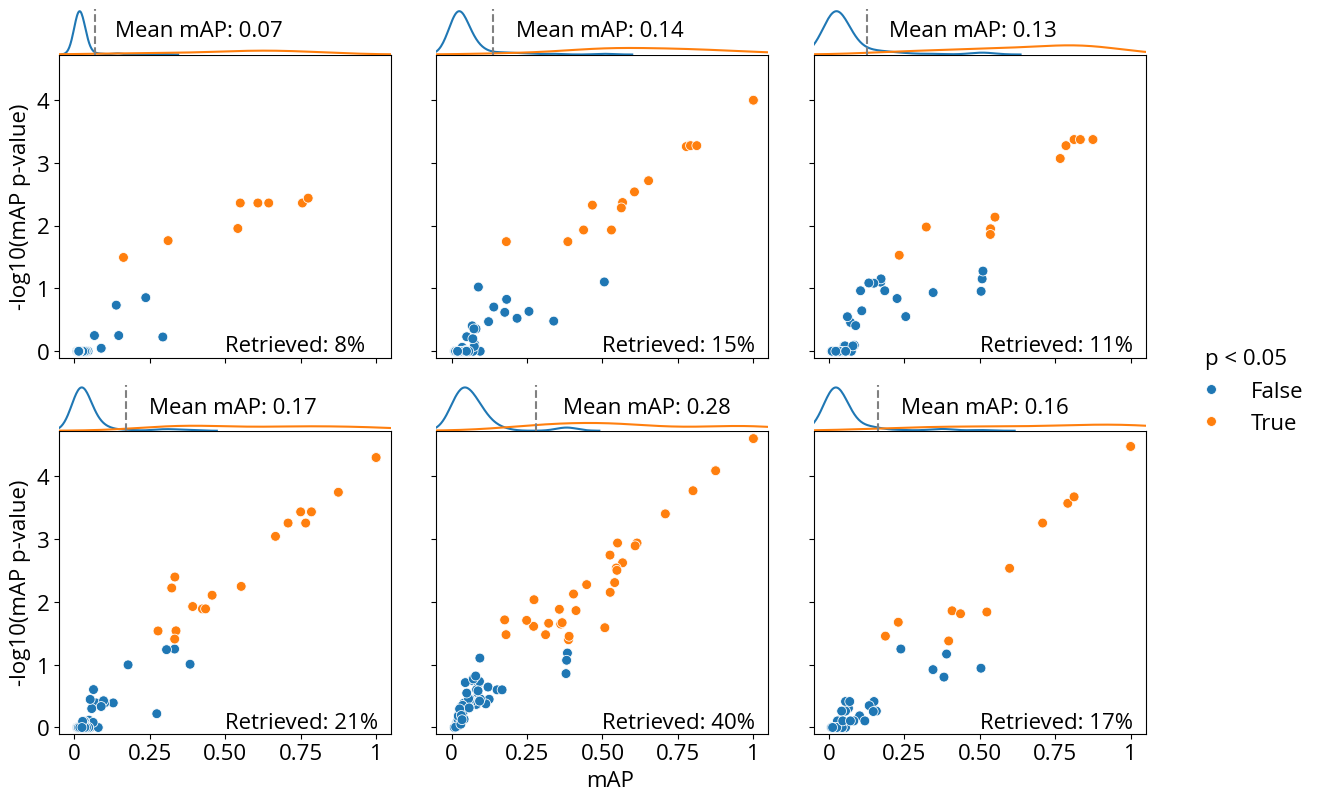

In [13]:
plot_map_x3(results, "mode", "Standardized", row="Preprocessing", move_legend="center left", pr_x=0.5, pr_y=0.02)

In [14]:
perts_6_wells = ch_mad_df.query("Metadata_cell_line == 'A549'").groupby("Metadata_pert_name")["Metadata_Well"].count()
perts_6_wells = perts_6_wells[perts_6_wells == 6].index.tolist()
pert_6_wells_and_controls = perts_6_wells + control_barcodes["cutting_control"]
ch_mad_df_6wells = ch_mad_df.query("Metadata_pert_name != 'EMPTY' and Metadata_pert_name in @pert_6_wells_and_controls").reset_index(drop=True)
ch_mad_df_6wells["Metadata_is_control"] = ch_mad_df_6wells.Metadata_pert_name.isin(
    control_barcodes["cutting_control"]
).astype(int)
ch_mad_df_6wells

,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_SumAverage_ER_20_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Metadata_is_control
0,SQ00014612,A02,2,A,A549,MCL1,MCL1-5,0.739037,-0.466950,2.245620,...,2.099596,0.387399,1.606377,0.619004,-1.123289,1.319333,1.126989,1.149692,0.538925,0
1,SQ00014612,A03,3,A,A549,AKT1,AKT1-1,0.663179,-0.614422,1.552016,...,1.447807,0.372708,1.232601,0.744217,0.065222,1.338340,2.086322,1.824093,0.076692,0
2,SQ00014612,A04,4,A,A549,KRAS,KRAS-2B,1.142720,-1.444163,2.473148,...,2.102723,1.144608,2.397073,1.158156,-1.639257,1.082772,0.468119,0.520477,-0.689098,0
3,SQ00014612,A05,5,A,A549,AKT1,AKT1-2,0.506535,-0.384485,2.334123,...,1.380920,-0.091729,1.584126,0.110702,-0.332856,0.630777,1.554514,1.547912,0.029147,0
4,SQ00014612,A07,7,A,A549,BRAF1,BRAF1-1,0.227811,0.103333,1.002592,...,-0.320628,-1.072588,-0.521099,-0.880352,-0.547010,0.124271,-0.837735,-0.832997,0.211909,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,SQ00014613,P12,12,P,ES2,Luc,Luc-1,0.907206,-0.632729,-0.540148,...,-0.534540,-0.226489,-0.568982,-0.568961,-0.999142,-0.761526,-0.088524,-0.508075,-1.062936,1
2372,SQ00014613,P13,13,P,ES2,Chr2,Chr2-2,0.107181,0.473512,0.443804,...,-0.877828,-0.575522,-0.754986,-0.583208,0.258537,-0.174021,0.684750,-0.363910,0.023338,1
2373,SQ00014613,P17,17,P,ES2,Chr2,Chr2-5,-0.927280,0.979029,0.144797,...,-0.740496,-1.334831,-1.360276,-1.143278,-1.222559,-1.142985,-0.558143,-0.944393,0.417483,1
2374,SQ00014613,P20,20,P,ES2,Chr2,Chr2-4,-0.682856,1.065890,0.249829,...,-1.377794,-1.181549,-0.949335,-1.054564,0.215409,0.147263,0.291476,-0.281496,1.065962,1


In [15]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_pert_name", "Metadata_is_control == 0"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Metadata_is_control"], "any": []},
    # "neg_diffby": {"all": ["Metadata_is_control", "Metadata_Plate"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_pert_name"],
    },
}

results = []

for cell_type in ch_mad_df_6wells.Metadata_cell_line.unique():
    print(f"\nProcessing cell type: {cell_type}")
    df = ch_mad_df_6wells.query("Metadata_cell_line == @cell_type").reset_index(drop=True)

    # pair_config["pos_sameby"]["all"].extend(value["pos_sameby"]["all"])
    # pair_config["pos_diffby"]["all"].extend(value["pos_diffby"]["all"])

    # map_results = calc_map(ch_dfA549_6wells_2plates, pair_config, map_config)
    map_results = calc_map(df, pair_config, map_config)
    map_results["cell_type"] = cell_type
    results.append(map_results)


results = pd.concat(results).reset_index(drop=True)


Processing cell type: A549

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: HCC44

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: ES2

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)


/tmp/ipykernel_15303/582035682.py:240: UserWarning: The figure layout has changed to tight


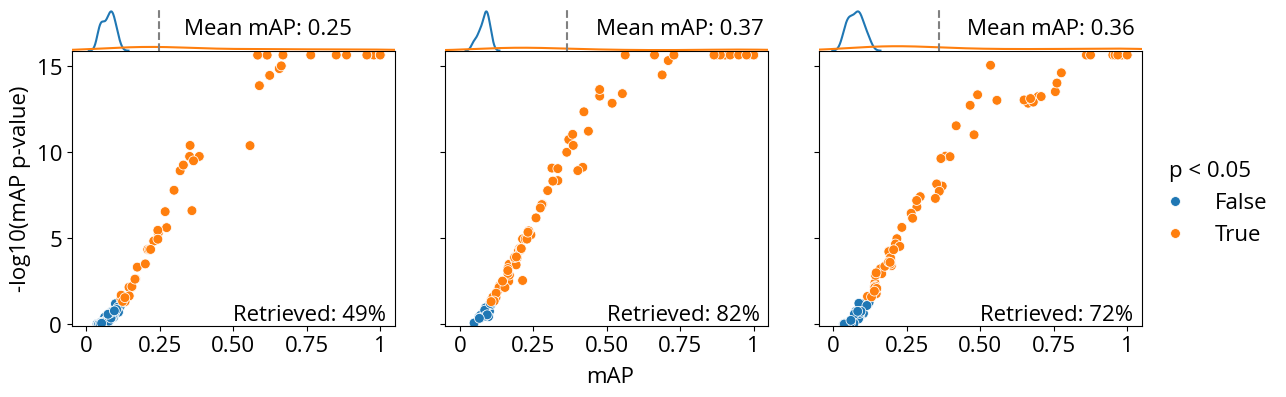

In [16]:
plot_map_x3(results, "cell_type", "", move_legend="lower right", pr_x=0.5, pr_y=0.02, l_x=1.02, l_y=0.6)

#### Empty controls

In [17]:
pert_6_wells_and_empty = perts_6_wells + control_barcodes["perturbation_control"]
ch_mad_df_6wells_empty = ch_mad_df.query("Metadata_pert_name in @pert_6_wells_and_empty").reset_index(drop=True)
ch_mad_df_6wells_empty["Metadata_is_control"] = ch_mad_df_6wells_empty.Metadata_pert_name.isin(
    control_barcodes["perturbation_control"]
).astype(int)
ch_mad_df_6wells_empty

,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_SumAverage_ER_20_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Metadata_is_control
0,SQ00014612,A01,1,A,A549,EMPTY,EMPTY,-0.378191,-0.030782,2.089629,...,2.556333,0.635753,2.262901,1.020190,-1.051497,1.690149,1.211959,0.904173,0.283193,1
1,SQ00014612,A02,2,A,A549,MCL1,MCL1-5,0.739037,-0.466950,2.245620,...,2.099596,0.387399,1.606377,0.619004,-1.123289,1.319333,1.126989,1.149692,0.538925,0
2,SQ00014612,A03,3,A,A549,AKT1,AKT1-1,0.663179,-0.614422,1.552016,...,1.447807,0.372708,1.232601,0.744217,0.065222,1.338340,2.086322,1.824093,0.076692,0
3,SQ00014612,A04,4,A,A549,KRAS,KRAS-2B,1.142720,-1.444163,2.473148,...,2.102723,1.144608,2.397073,1.158156,-1.639257,1.082772,0.468119,0.520477,-0.689098,0
4,SQ00014612,A05,5,A,A549,AKT1,AKT1-2,0.506535,-0.384485,2.334123,...,1.380920,-0.091729,1.584126,0.110702,-0.332856,0.630777,1.554514,1.547912,0.029147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,SQ00014613,P09,9,P,ES2,EMPTY,EMPTY,-0.959796,1.644603,0.739399,...,-1.681278,-0.769610,-0.863499,-0.816717,-0.003201,0.112262,-1.796580,-0.699833,0.944834,1
2300,SQ00014613,P11,11,P,ES2,EMPTY,EMPTY,-0.675531,0.715790,-0.509301,...,-0.038013,0.248176,0.276340,-0.007053,0.271630,0.024107,1.466374,0.313274,-0.214722,1
2301,SQ00014613,P14,14,P,ES2,EMPTY,EMPTY,0.184199,0.418367,0.359364,...,-1.113104,-0.716220,-0.889552,-0.724802,-0.154842,-0.178666,-0.666153,-0.426719,0.352312,1
2302,SQ00014613,P16,16,P,ES2,EMPTY,EMPTY,-0.317676,0.385354,-0.651451,...,-1.489044,-0.475815,-0.097800,-0.470294,0.793166,0.545455,-0.546092,-0.406909,0.563447,1


In [18]:
empty_results = []

for cell_type in ch_mad_df_6wells_empty.Metadata_cell_line.unique():
    print(f"\nProcessing cell type: {cell_type}")
    df = ch_mad_df_6wells_empty.query("Metadata_cell_line == @cell_type").reset_index(drop=True)

    map_results = calc_map(df, pair_config, map_config)
    map_results["cell_type"] = cell_type
    empty_results.append(map_results)


empty_results = pd.concat(empty_results).reset_index(drop=True)



Processing cell type: A549

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 100800


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: HCC44

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 100800


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: ES2

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 100800


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)


/tmp/ipykernel_15303/582035682.py:240: UserWarning: The figure layout has changed to tight


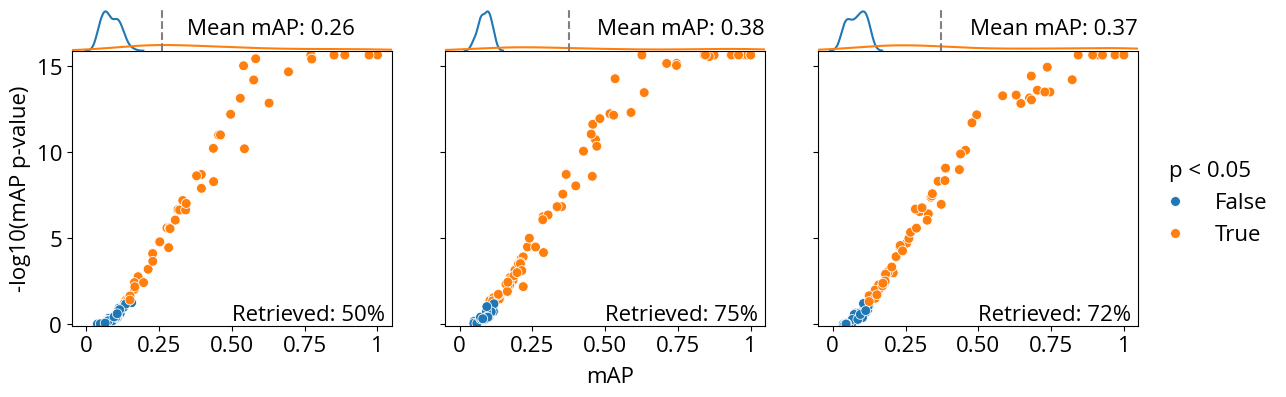

In [19]:
plot_map_x3(empty_results, "cell_type", "", move_legend="lower right", pr_x=0.5, pr_y=0.02, l_x=1.02, l_y=0.6)

In [20]:
results["control_barcodes"] = "cutting_control"
empty_results["control_barcodes"] = "perturbation_control"
guide_results = pd.concat([results, empty_results]).reset_index(drop=True)
guide_results = guide_results.merge(ch_mad_df[["Metadata_gene_name", "Metadata_pert_name"]].drop_duplicates(), on="Metadata_pert_name", how="left")
guide_results.to_csv("../../1.calculate-metrics/cell-health/results/cell_health_guide_map.tsv", sep="\t", index=False)
guide_results

,Metadata_pert_name,mAP,p_value,n_pos_pairs,n_total_pairs,-log10(mAP p-value),p < 0.05,cell_type,control_barcodes,Metadata_gene_name
0,AKT1-1,0.091418,3.435411e-01,5.0,197.0,0.464021,False,A549,cutting_control,AKT1
1,AKT1-2,0.079981,3.435411e-01,5.0,197.0,0.464021,False,A549,cutting_control,AKT1
2,ARID1B-1,0.073996,3.435411e-01,5.0,197.0,0.464021,False,A549,cutting_control,ARID1B
3,ARID1B-2,0.062915,6.874969e-01,5.0,197.0,0.162729,False,A549,cutting_control,ARID1B
4,ATF4-1,0.656365,1.383255e-15,5.0,197.0,14.859098,True,A549,cutting_control,ATF4
...,...,...,...,...,...,...,...,...,...,...
595,TXN-2,0.113517,1.656909e-01,5.0,173.0,0.780701,False,ES2,perturbation_control,TXN
596,XBP-1,0.172361,4.221318e-03,5.0,173.0,2.374552,True,ES2,perturbation_control,XBP
597,XBP-2,0.306686,1.717010e-07,5.0,173.0,6.765227,True,ES2,perturbation_control,XBP
598,YAP1-1,0.478270,1.957553e-12,5.0,173.0,11.708286,True,ES2,perturbation_control,YAP1


In [21]:
replicability_results = results.copy()

In [22]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_pert_name", "Metadata_is_control == 0"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Metadata_is_control"], "any": []},
    # "neg_diffby": {"all": ["Metadata_is_control", "Metadata_Plate"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_pert_name"],
    },
}



results = []
channels = ["DNA", "RNA", "Mito", "AGP", "ER"]
meta_features = ch_mad_df_6wells.filter(regex="Metadata_").columns.tolist()

for cell_type in ch_mad_df_6wells.Metadata_cell_line.unique():
    print(f"\nProcessing cell type: {cell_type}")
    df = ch_mad_df_6wells.query("Metadata_cell_line == @cell_type").reset_index(drop=True)

    for channel in channels:
        channel_features = df.loc[:, df.columns.str.contains(channel)].columns.tolist()

        for drop in [True, False]:
            if drop:
                subset_df = df.drop(channel_features, axis="columns")
                dropped_or_exclusive = "dropped"
                use_features = subset_df.drop(meta_features, axis="columns").columns.tolist()
            else:
                subset_df = df.loc[:, meta_features + channel_features]
                dropped_or_exclusive = "exclusive"
                use_features = channel_features

            map_results = calc_map(subset_df, pair_config, map_config)
            map_results["cell_type"] = cell_type
            map_results["channel"] = channel
            map_results["dropped_or_exclusive"] = dropped_or_exclusive
            results.append(map_results)

results = pd.concat(results)


Processing cell type: A549

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: HCC44

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: ES2

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)


In [23]:
results

,Metadata_pert_name,mAP,p_value,n_pos_pairs,n_total_pairs,-log10(mAP p-value),p < 0.05,cell_type,channel,dropped_or_exclusive
0,AKT1-1,0.087415,4.462795e-01,5.0,197.0,0.350393,False,A549,DNA,dropped
1,AKT1-2,0.062043,5.899550e-01,5.0,197.0,0.229181,False,A549,DNA,dropped
2,ARID1B-1,0.082788,1.526936e-01,5.0,197.0,0.816179,False,A549,DNA,dropped
3,ARID1B-2,0.071251,5.341290e-01,5.0,197.0,0.272354,False,A549,DNA,dropped
4,ATF4-1,0.640589,9.918643e-16,5.0,197.0,15.003548,True,A549,DNA,dropped
...,...,...,...,...,...,...,...,...,...,...
95,TXN-2,0.180295,5.464673e-04,5.0,197.0,3.262436,True,ES2,ER,exclusive
96,XBP-1,0.179390,1.612428e-03,5.0,197.0,2.792520,True,ES2,ER,exclusive
97,XBP-2,0.193778,1.186815e-04,5.0,197.0,3.925617,True,ES2,ER,exclusive
98,YAP1-1,0.297437,1.555451e-07,5.0,197.0,6.808144,True,ES2,ER,exclusive


In [24]:
results_channel = results.groupby(["channel", "dropped_or_exclusive"])[["mAP", "p < 0.05"]].mean().reset_index()
results_channel

,channel,dropped_or_exclusive,mAP,p < 0.05
0,AGP,dropped,0.320891,0.663333
1,AGP,exclusive,0.271651,0.593333
2,DNA,dropped,0.327810,0.680000
3,DNA,exclusive,0.266387,0.563333
4,ER,dropped,0.326095,0.683333
5,ER,exclusive,0.270735,0.563333
6,Mito,dropped,0.309563,0.623333
7,Mito,exclusive,0.306333,0.716667
8,RNA,dropped,0.329482,0.686667
9,RNA,exclusive,0.260944,0.560000


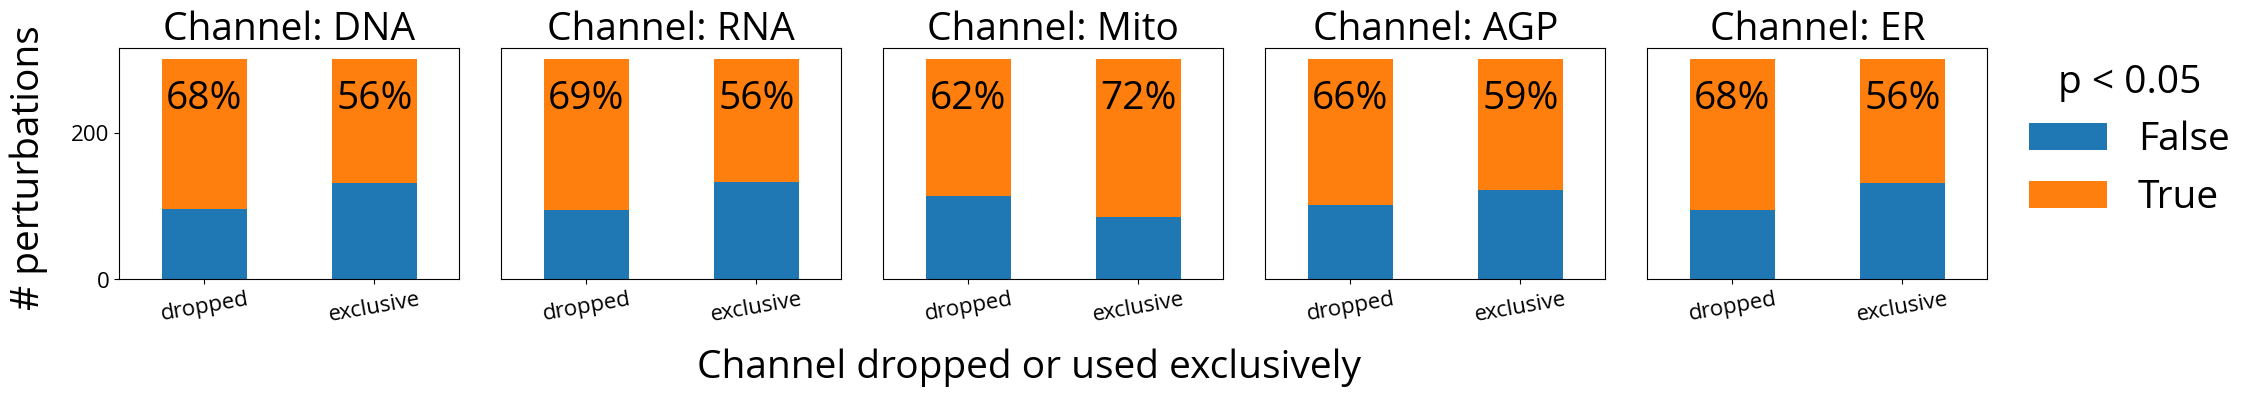

In [25]:
l_x=1.05
l_y=0.85

fontsize=28

channels = results['channel'].unique()
n_channels = len(channels)

fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))  # Adjust the size as needed
axes = axes.flatten()  # Flatten in case of a single row of subplots

plt.rcParams["font.family"] = ["Open Sans"]
plt.rcParams["font.size"] = fontsize

for i_ch, (channel, ax) in enumerate(zip(channels, axes)):

    df_channel = results[results['channel'] == channel]
    grouped = df_channel.groupby(['dropped_or_exclusive', 'p < 0.05'])['mAP'].count().unstack(fill_value=0)
    bars = grouped.plot(kind='bar', stacked=True, ax=ax, rot=10)
    
    ax.set_title(f"Channel: {channel}", fontsize=fontsize)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    if i_ch != 0:
        ax.get_yaxis().set_visible(False)

    for i, rect in enumerate(bars.patches):
         if i % len(bars.patches) // 2 != 0:
            # Calculate the mean for the corresponding group
            group_mean = df_channel[df_channel['dropped_or_exclusive'] == grouped.index[i % len(grouped.index)]]['p < 0.05'].mean()
            
            # Get the position for the text
            height = rect.get_height()
            x = rect.get_x() + rect.get_width() / 2.0
            y = rect.get_y() + height - 1

            # Place the text on top of the bar
            ax.text(x, 220, f"{group_mean:.0%}", ha='center', va='bottom', fontsize=fontsize, color='black')


fig.text(0.5, 0.0, 'Channel dropped or used exclusively', ha='center', va='center', fontsize=fontsize)
fig.text(0.0, 0.5, '# perturbations', ha='center', va='center', rotation='vertical', fontsize=fontsize)

fig.legend(handles, labels, title="p < 0.05", loc="upper center", bbox_to_anchor=(l_x, l_y), frameon=False)
plt.tight_layout()
plt.show()


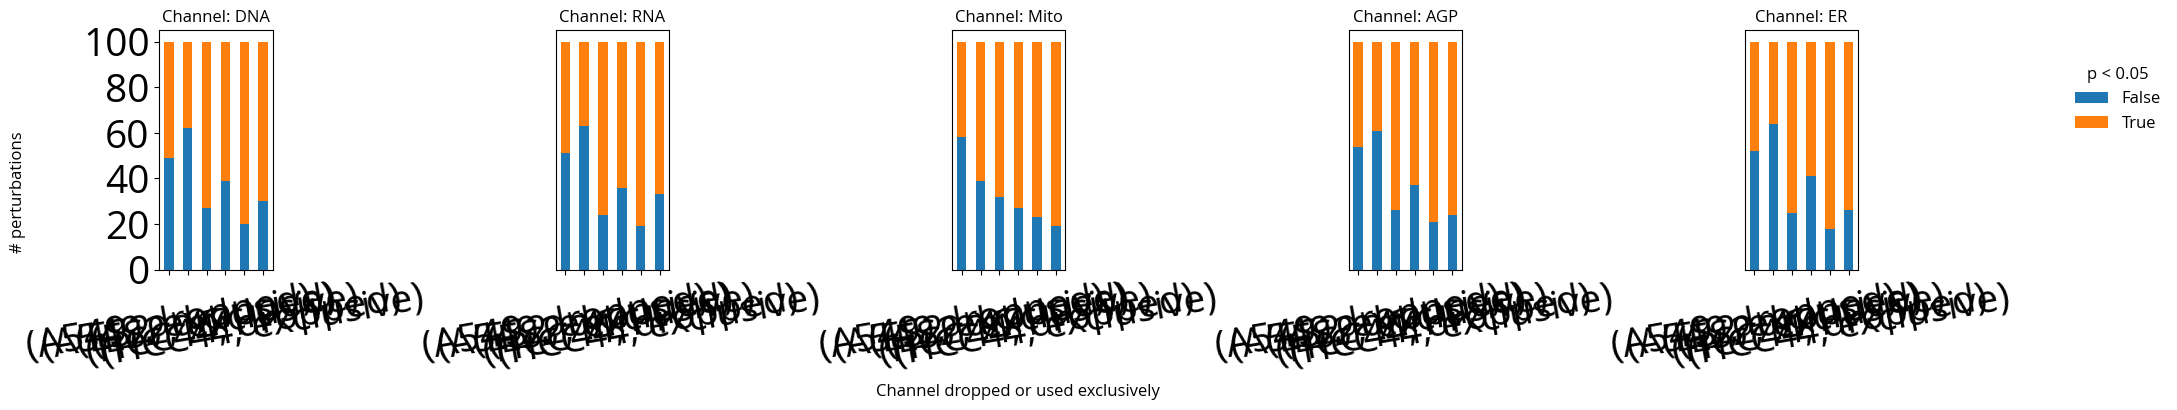

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Set up the figure and axes
channels = results['channel'].unique()
n_channels = len(channels)
fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))  # Unmodified
axes = axes.flatten()  # Unmodified

# Font settings
fontsize = 12  # Unmodified
plt.rcParams["font.family"] = ["Open Sans"]  # Unmodified
plt.rcParams["font.size"] = fontsize  # Unmodified

# Plotting each channel
l_x = 1.05  # Unmodified
l_y = 0.85  # Unmodified
for i_ch, (channel, ax) in enumerate(zip(channels, axes)):  # Unmodified
    df_channel = results[results['channel'] == channel]  # Unmodified
    
    # Group by 'dropped_or_exclusive', 'p < 0.05', and 'cell_type'
    grouped = df_channel.groupby(['cell_type', 'dropped_or_exclusive', 'p < 0.05'])['mAP'].count().unstack(fill_value=0)
    
    # Plotting separate stacked bars for each 'cell_type'
    grouped = grouped.reindex(grouped.mean().sort_values().index, axis=1)  # Sorting 'cell_type' for consistent order
    grouped.plot(kind='bar', stacked=True, ax=ax, rot=10)

    # Set the title and remove axis labels
    ax.set_title(f"Channel: {channel}", fontsize=fontsize)  # Unmodified
    handles, labels = ax.get_legend_handles_labels()  # Unmodified
    ax.get_legend().remove()  # Unmodified
    ax.xaxis.label.set_visible(False)  # Unmodified
    ax.yaxis.label.set_visible(False)  # Unmodified

    # Hide y-axis for all but the first subplot
    if i_ch != 0:  # Unmodified
        ax.get_yaxis().set_visible(False)  # Unmodified

    # Text annotations for group means (Optional: can be modified or removed as needed)
    # for i, rect in enumerate(ax.patches):  # Unmodified
        # Calculate the mean for the corresponding group (Optional)
        # Place the text on top of the bar (Optional)

# Common figure labels and legend
fig.text(0.5, 0.0, 'Channel dropped or used exclusively', ha='center', va='center', fontsize=fontsize)  # Unmodified
fig.text(0.0, 0.5, '# perturbations', ha='center', va='center', rotation='vertical', fontsize=fontsize)  # Unmodified
fig.legend(handles, labels, title="p < 0.05", loc="upper center", bbox_to_anchor=(l_x, l_y), frameon=False, fontsize=fontsize)  # Unmodified

# Layout adjustments
plt.tight_layout()  # Unmodified
plt.show()  # Unmodified


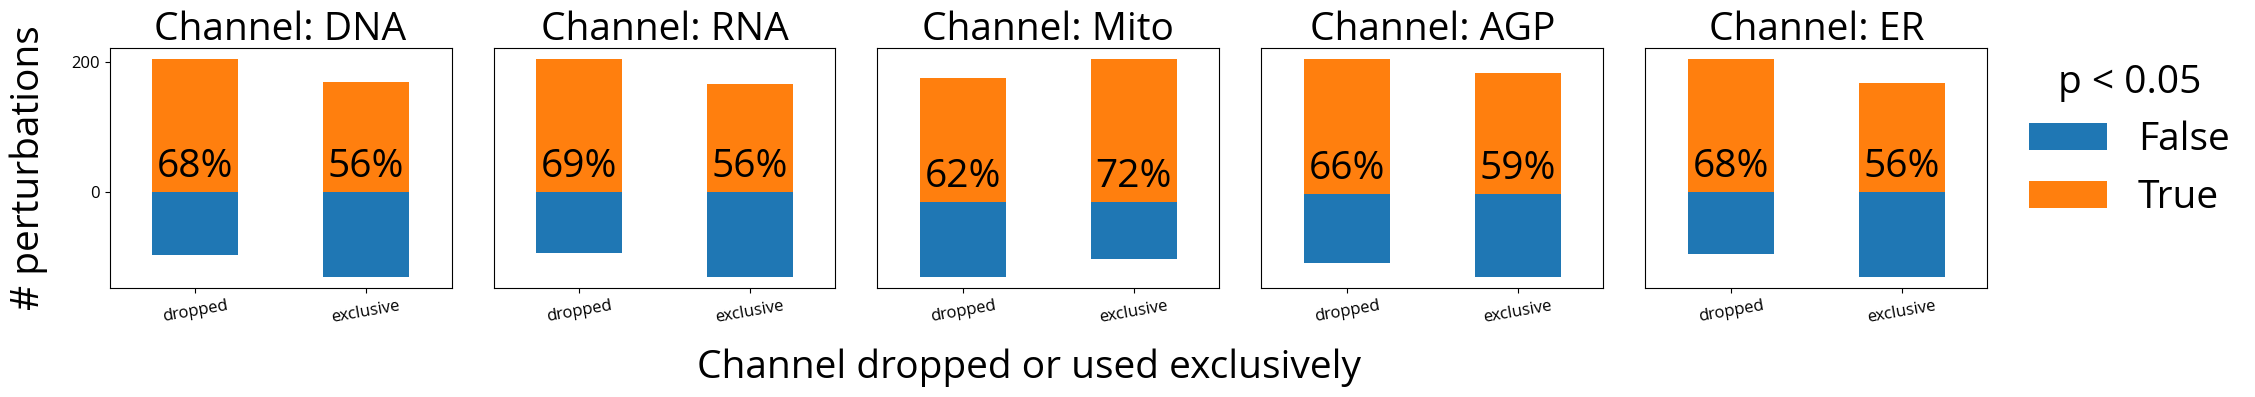

In [27]:

channels = results['channel'].unique()
n_channels = len(channels)
fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))  # Unmodified
axes = axes.flatten()  # Unmodified

# Font settings
fontsize = 28  # Unmodified
plt.rcParams["font.family"] = ["Open Sans"]  # Unmodified
plt.rcParams["font.size"] = fontsize  # Unmodified

# Plotting each channel
l_x = 1.05  # Unmodified
l_y = 0.85  # Unmodified
for i_ch, (channel, ax) in enumerate(zip(channels, axes)):  # Unmodified
    df_channel = results[results['channel'] == channel]  # Unmodified
    grouped = df_channel.groupby(['dropped_or_exclusive', 'p < 0.05'])['mAP'].count().unstack(fill_value=0)  # Unmodified

    # Create diverging bars
    # One part of the group will be positive, and the other negative
    grouped[False] = -grouped[False]  # Make 'p < 0.05' == True group negative for diverging plot

    # Plot the modified grouped data
    bars = grouped.plot(kind='bar', stacked=True, ax=ax, rot=10)  # Modified to plot diverging bars

    # Set the title and remove axis labels
    ax.set_title(f"Channel: {channel}", fontsize=fontsize)  # Unmodified
    handles, labels = ax.get_legend_handles_labels()  # Unmodified
    ax.get_legend().remove()  # Unmodified
    ax.xaxis.label.set_visible(False)  # Unmodified
    ax.yaxis.label.set_visible(False)  # Unmodified

    # Hide y-axis for all but the first subplot
    if i_ch != 0:  # Unmodified
        ax.get_yaxis().set_visible(False)  # Unmodified

    # Add text annotations
    for i, rect in enumerate(bars.patches):  # Unmodified
        if i % len(bars.patches) // 2 != 0:  # Unmodified
            group_mean = df_channel[df_channel['dropped_or_exclusive'] == grouped.index[i % len(grouped.index)]]['p < 0.05'].mean()  # Unmodified
            height = rect.get_height()  # Unmodified
            x = rect.get_x() + rect.get_width() / 2.0  # Unmodified
            y = rect.get_y() + height - 1  # Unmodified
            ax.text(x, 10, f"{group_mean:.0%}", ha='center', va='bottom', fontsize=fontsize, color='black')  # Unmodified

# Add common figure text and legend
fig.text(0.5, 0.0, 'Channel dropped or used exclusively', ha='center', va='center', fontsize=fontsize)  # Unmodified
fig.text(0.0, 0.5, '# perturbations', ha='center', va='center', rotation='vertical', fontsize=fontsize)  # Unmodified
fig.legend(handles, labels, title="p < 0.05", loc="upper center", bbox_to_anchor=(l_x, l_y), frameon=False)  # Unmodified

# Layout adjustments
plt.tight_layout()  # Unmodified
plt.show()  # Unmodified


In [28]:
per_channel_df = results.pivot_table(
        index=["Metadata_pert_name", "cell_type", "channel"],
        values="-log10(mAP p-value)",
        columns="dropped_or_exclusive",
).reset_index()

per_channel_df = (
    per_channel_df.assign(channel_signal=per_channel_df.exclusive - per_channel_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_channel_df.shape)
per_channel_df.head(10)

(1500, 6)


dropped_or_exclusive,Metadata_pert_name,cell_type,channel,dropped,exclusive,channel_signal
0,SLC2A1-1,A549,Mito,0.030707,13.719917,13.689210
1,SLC2A1-1,HCC44,Mito,4.971714,14.028749,9.057035
2,EGLN1-8,ES2,Mito,8.104496,15.653560,7.549063
3,SDHB-1,HCC44,Mito,6.143838,13.469945,7.326107
4,ERBB3-1,HCC44,Mito,0.743624,7.607315,6.863691
5,BRAF1-1,HCC44,DNA,1.172881,7.976933,6.804051
6,EGLN1-8,HCC44,Mito,7.915994,14.551476,6.635483
7,COX5B-1,A549,Mito,0.000898,6.319431,6.318533
8,EGFR-2,HCC44,DNA,0.862130,6.787346,5.925215
9,XBP-2,ES2,Mito,5.380310,10.800974,5.420664


In [29]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}

compartment_drop_theme = gg.theme(
    strip_background=gg.element_rect(color="black", fill="#fdfff4"),
    strip_text_x=gg.element_text(size=12),
    axis_text=gg.element_text(size=12),
    axis_title=gg.element_text(size=12),
    legend_title=gg.element_text(size=12),
    legend_text=gg.element_text(size=12),
    panel_grid=gg.element_line(size=0.35),
)

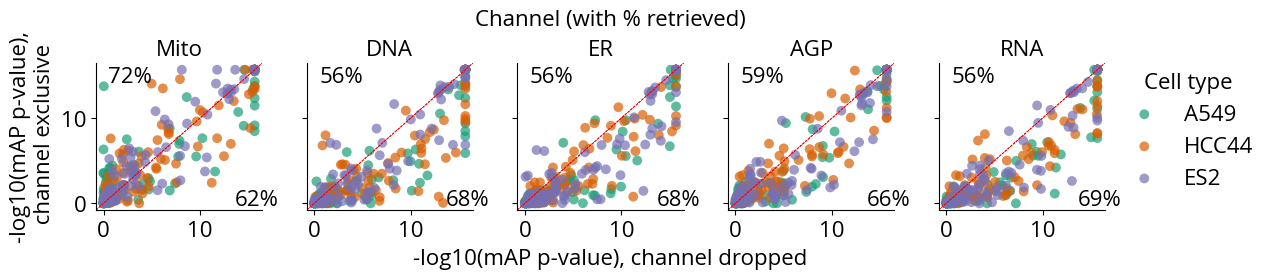

In [30]:
# restore settings
plt.rcParams["font.family"] = ["Open Sans"]
plt.rcParams["font.size"] = 16

cell_line_colors = {"A549": "#1b9e77", "HCC44": "#d95f02", "ES2": "#7570b3"}
g = sns.FacetGrid(per_channel_df, col="channel", hue="cell_type", height=3, aspect=.75, palette=cell_line_colors)
g.map(sns.scatterplot, "dropped", "exclusive", alpha=0.7, s=50, edgecolor='none')

def add_diag_line(*args, **kwargs):
    plt.gca().axline((0, 0), slope=1, color="red", linestyle="dashed", lw=0.5)
g.map(add_diag_line)

# for ax, (_, sub_data) in zip(g.axes.flatten(), g.facet_data()):
#     add_text_annotations(ax, sub_data)

# Calculate the overall mean values for each channel across all cell types
overall_means = per_channel_df.groupby('channel').apply(lambda x: pd.Series({
    'dropped_mean': (x['dropped'] > 1.301).mean(),
    'exclusive_mean': (x['exclusive'] > 1.301).mean()
}))

# Apply text annotations using overall means
channels = per_channel_df['channel'].unique()
for ax, channel in zip(g.axes.flatten(), channels):
    dropped_percent = overall_means.loc[channel, 'dropped_mean']
    exclusive_percent = overall_means.loc[channel, 'exclusive_mean']
    ax.text(0.075, 0.98, f"{exclusive_percent:.0%}", transform=ax.transAxes, ha='left', va='top')
    ax.text(1.1, 0.0, f"{dropped_percent:.0%}", transform=ax.transAxes, ha='right', va='bottom')

# g.set_axis_labels("-log10(mAP p-value)\n(channel dropped)", "-log10(mAP p-value)\n(channel only)")
g.set_xlabels("")
g.set_ylabels("-log10(mAP p-value),\n channel exclusive")
g.fig.text(0.48, 0.98, 'Channel (with % retrieved)', ha='center', va='center')
g.fig.text(0.48, 0.025, '-log10(mAP p-value), channel dropped', ha='center', va='center')

g.set_titles("{col_name}")

# Increase the width of the figure
g.fig.set_size_inches(13, 2.5)  # Adjust width as needed

# Manually draw the legend
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)

# Adjust subplot parameters to make space for the legend
g.fig.subplots_adjust(right=0.75)  # Adjust this value as needed

plt.tight_layout()
plt.show()


In [31]:
channels

array(['Mito', 'DNA', 'ER', 'AGP', 'RNA'], dtype=object)

In [32]:
compartments = ["Cells", "Cytoplasm", "Nuclei"]
meta_features = ch_mad_df_6wells.filter(regex="Metadata_").columns.tolist()
all_features = infer_cp_features(ch_mad_df_6wells, compartments=compartments)

feature_groups = ["AreaShape", "Correlation", "Granularity", "Intensity", "RadialDistribution", "Texture"]
process_features = [f for f in all_features if any(f"_{fg}_" in f for fg in feature_groups)]

feature_group_compartments = list(set(["_".join(x.split("_")[0:2]) for x in process_features]))
feature_group_compartments

['Cells_Intensity',
 'Cytoplasm_Texture',
 'Nuclei_Intensity',
 'Cells_RadialDistribution',
 'Cytoplasm_Intensity',
 'Cytoplasm_Correlation',
 'Cytoplasm_RadialDistribution',
 'Cells_Correlation',
 'Cells_Texture',
 'Nuclei_RadialDistribution',
 'Nuclei_AreaShape',
 'Nuclei_Texture',
 'Cells_AreaShape',
 'Cytoplasm_Granularity',
 'Nuclei_Granularity',
 'Nuclei_Correlation',
 'Cells_Granularity',
 'Cytoplasm_AreaShape']

In [33]:
map_subcompartment_results = []
for cell_line in ch_mad_df_6wells.Metadata_cell_line.unique():
    
    print(f"\nProcessing cell type: {cell_type}")
    df = ch_mad_df_6wells.query("Metadata_cell_line == @cell_line").reset_index(drop=True)
    
    for compartment_group in feature_group_compartments:
        compartment, feature_group = compartment_group.split("_")
        compartment_features = df.loc[:, df.columns.str.startswith(compartment_group)].columns.tolist()

        for drop in [True, False]:
            if drop:
                subset_df = df.drop(compartment_features, axis="columns")
                dropped_or_exclusive = "dropped"
                use_features = subset_df.drop(meta_features, axis="columns").columns.tolist()
            else:
                subset_df = df.loc[:, meta_features + compartment_features]
                dropped_or_exclusive = "exclusive"
                use_features = compartment_features

            subset_df["Metadata_is_control"] = subset_df.Metadata_pert_name.isin(control_barcodes["cutting_control"]).astype(int)

            map_results = calc_map(subset_df.reset_index(drop=True), pair_config, map_config)
            map_results["cell_line"] = cell_line
            map_results["compartment"] = compartment
            map_results["feature_group"] = feature_group
            map_results["dropped_or_exclusive"] = dropped_or_exclusive
            map_subcompartment_results.append(map_results)

map_subcompartment_results = pd.concat(map_subcompartment_results).reset_index(drop=True)


Processing cell type: ES2

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: ES2

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Processing cell type: ES2

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)

Calculating distances.
Pos pairs size: 1500, Neg pairs size: 115200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

(100, 7)


In [34]:
map_subcompartment_results

,Metadata_pert_name,mAP,p_value,n_pos_pairs,n_total_pairs,-log10(mAP p-value),p < 0.05,cell_line,compartment,feature_group,dropped_or_exclusive
0,AKT1-1,0.091828,3.367486e-01,5.0,197.0,4.726942e-01,False,A549,Cells,Intensity,dropped
1,AKT1-2,0.078705,3.305830e-01,5.0,197.0,4.807195e-01,False,A549,Cells,Intensity,dropped
2,ARID1B-1,0.077367,2.717874e-01,5.0,197.0,5.657706e-01,False,A549,Cells,Intensity,dropped
3,ARID1B-2,0.062099,6.974101e-01,5.0,197.0,1.565118e-01,False,A549,Cells,Intensity,dropped
4,ATF4-1,0.656365,1.383255e-15,5.0,197.0,1.485910e+01,True,A549,Cells,Intensity,dropped
...,...,...,...,...,...,...,...,...,...,...,...
10795,TXN-2,0.034373,9.999992e-01,5.0,197.0,3.412667e-07,False,ES2,Cytoplasm,AreaShape,exclusive
10796,XBP-1,0.046888,9.999992e-01,5.0,197.0,3.412667e-07,False,ES2,Cytoplasm,AreaShape,exclusive
10797,XBP-2,0.056255,7.658516e-01,5.0,197.0,1.158554e-01,False,ES2,Cytoplasm,AreaShape,exclusive
10798,YAP1-1,0.374525,3.600860e-09,5.0,197.0,8.443594e+00,True,ES2,Cytoplasm,AreaShape,exclusive


In [35]:
per_featuregroup_df = (map_subcompartment_results.query("compartment != 'all'")
    .query("feature_group != 'all'")
    # .query("feature_group != 'Location'")
    # .query("channel == 'all'")
    # .query("feature_group != 'Location'")
).reset_index(drop=True)

per_featuregroup_df = per_featuregroup_df.pivot_table(
        index=[
            "Metadata_pert_name",
            # "Metadata_gene_name",
            "cell_line",
            # "channel",
            "feature_group",
            "compartment",
        ],
        values="-log10(mAP p-value)",
        columns="dropped_or_exclusive",
    ).reset_index()

per_featuregroup_df = (
    per_featuregroup_df.assign(channel_signal=per_featuregroup_df.exclusive - per_featuregroup_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_featuregroup_df.shape)
per_featuregroup_df.head(20)

(5400, 7)


dropped_or_exclusive,Metadata_pert_name,cell_line,feature_group,compartment,dropped,exclusive,channel_signal
0,TXN-1,HCC44,RadialDistribution,Nuclei,0.831518,12.825709,11.994191
1,YAP1-2,A549,RadialDistribution,Cells,0.705952,11.880291,11.174339
2,CTNNB1-1,A549,AreaShape,Cytoplasm,4.144621,13.468347,9.323726
3,RAC1-1,HCC44,Granularity,Cytoplasm,6.890782,15.653560,8.762777
4,CTNNB1-1,A549,AreaShape,Cells,3.567709,11.751691,8.183982
5,SLC2A1-1,A549,Texture,Nuclei,2.492507,10.027699,7.535193
6,EGLN1-9,A549,AreaShape,Nuclei,1.076717,8.561886,7.485169
7,TXN-1,ES2,Granularity,Nuclei,2.478336,9.691538,7.213203
8,SMARCB1-2,ES2,Granularity,Cells,6.149910,13.280470,7.130560
9,BRCA1-1,HCC44,AreaShape,Nuclei,2.192316,9.199770,7.007454


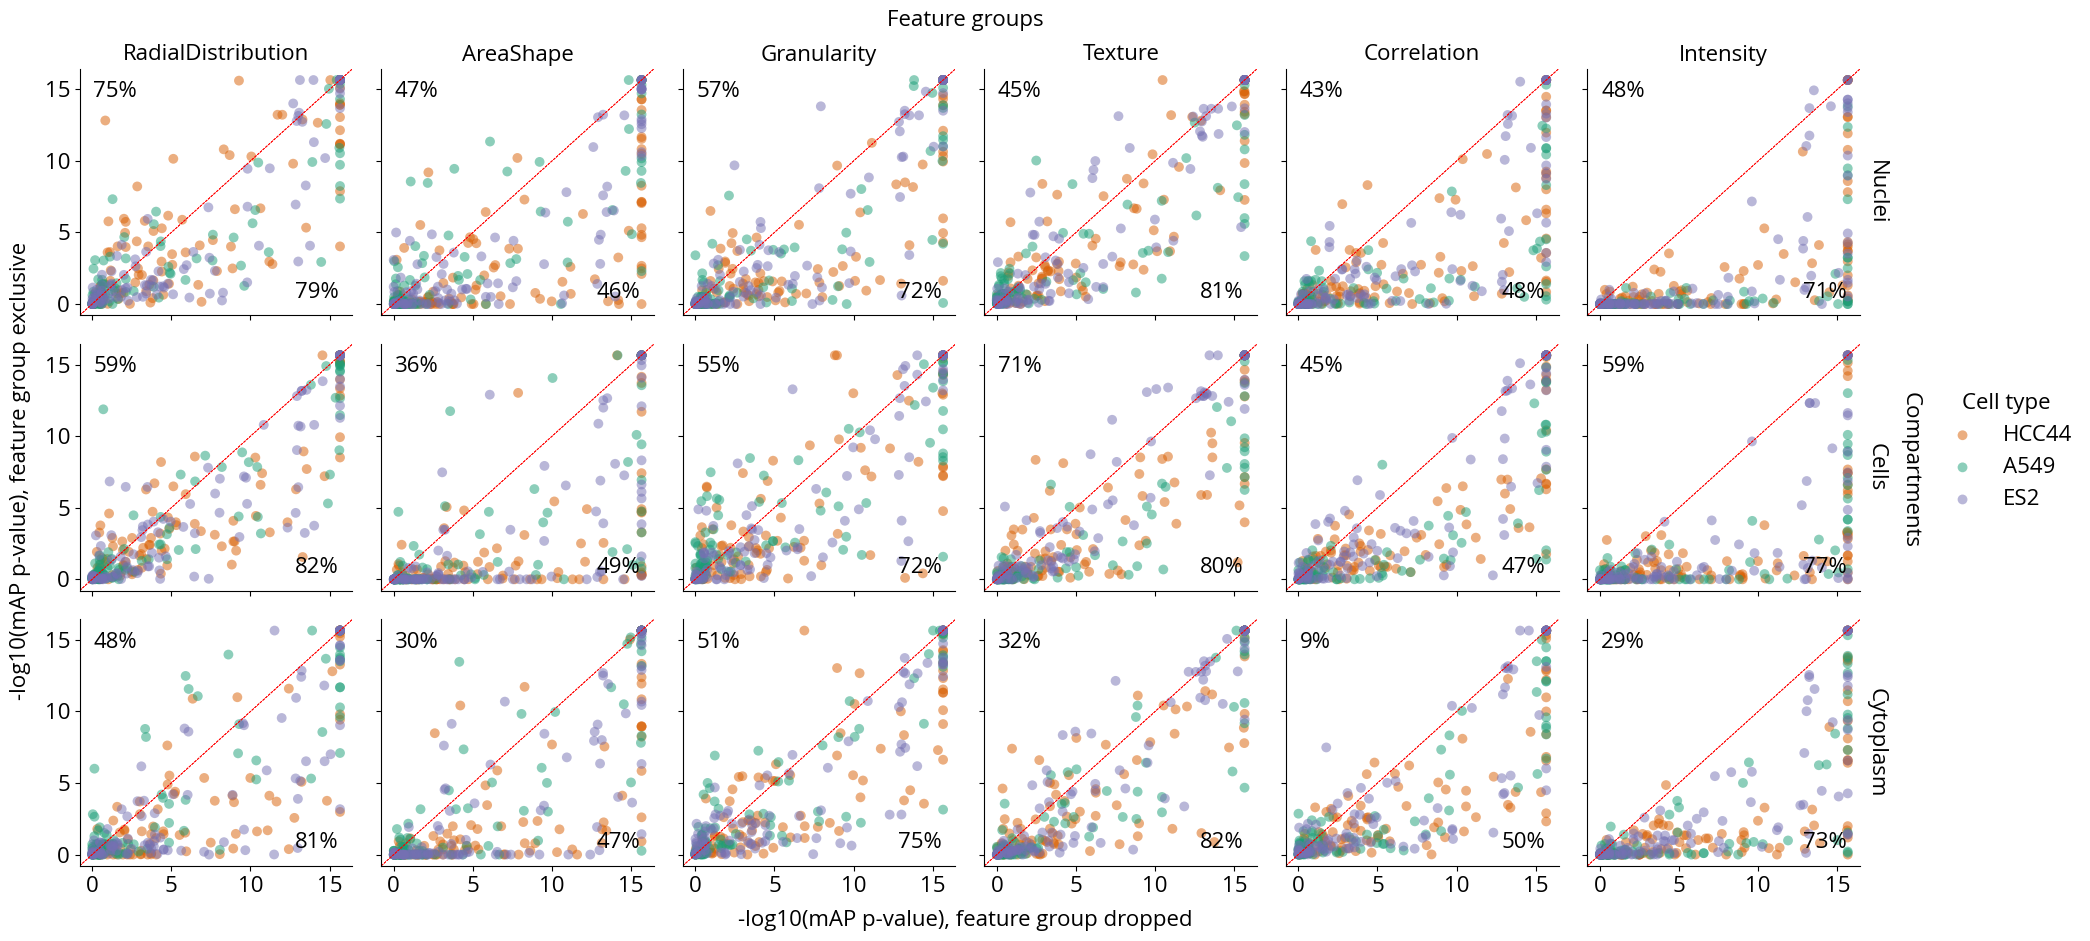

In [36]:
def add_text_annotations(ax, data):
    threshold = 1.301
    dropped_percent = (data['dropped'] > threshold).mean()
    exclusive_percent = (data['exclusive'] > threshold).mean()

    # Add text annotations
    ax.text(0.05, 0.95, f"{exclusive_percent:.0%}", transform=ax.transAxes, ha='left', va='top')  # Top left
    ax.text(0.95, 0.05, f"{dropped_percent:.0%}", transform=ax.transAxes, ha='right', va='bottom')

cell_line_colors = {"A549": "#1b9e77", "HCC44": "#d95f02", "ES2": "#7570b3"}
g = sns.FacetGrid(per_featuregroup_df, col="feature_group", row="compartment", hue="cell_line",
                  height=3, aspect=1.05,
                  palette=cell_line_colors,
                  margin_titles=True
                  )

g.map(sns.scatterplot, "dropped", "exclusive", alpha=0.5, s=50, edgecolor='none')

def add_diag_line(*args, **kwargs):
    plt.gca().axline((0, 0), slope=1, color="red", linestyle="dashed", lw=0.5)
g.map(add_diag_line)

for ax, (_, sub_data) in zip(g.axes.flatten(), g.facet_data()):
    add_text_annotations(ax, sub_data)

g.set_xlabels("")
g.set_ylabels("")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.text(0.5, 1.0, 'Feature groups', ha='center', va='center')
g.fig.text(0.5, 0.0, '-log10(mAP p-value), feature group dropped', ha='center', va='center')
g.fig.text(1.0, 0.5, 'Compartments', ha='center', va='center', rotation=270)
g.fig.text(0.0, 0.5, '-log10(mAP p-value), feature group exclusive', ha='center', va='center', rotation="vertical")

plt.tight_layout()
plt.legend(title="Cell type", bbox_to_anchor=(1.85, 2), frameon=False)
plt.show()


## Consistency

In [37]:
replicable_perts = replicability_results[(replicability_results["p < 0.05"] == True)].groupby("cell_type")["Metadata_pert_name"].unique()
replicable_perts

cell_type
A549     [ATF4-1, ATF4-2, ATP50-1, ATP50-2, BCL2-2, BRD...
ES2      [ARID1B-1, ATF4-1, ATF4-2, AURKB-2, BCL2L2-2, ...
HCC44    [AKT1-1, AKT1-2, ARID1B-1, ATF4-1, ATF4-2, ATP...
Name: Metadata_pert_name, dtype: object

In [38]:
ch_df_agg = aggregate(
    ch_mad_df_6wells,
    strata=["Metadata_pert_name", "Metadata_gene_name", "Metadata_cell_line"],
    features="infer"
)
ch_df_agg

,Metadata_pert_name,Metadata_gene_name,Metadata_cell_line,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumAverage_DNA_20_0,Nuclei_Texture_SumAverage_ER_20_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0
0,AKT1-1,AKT1,A549,0.341199,-0.229691,0.424161,0.165376,-0.033985,-0.211055,-0.055991,...,-0.009188,0.504725,0.217921,0.413354,0.452532,0.113044,0.557936,0.866277,0.541440,-0.047612
1,AKT1-1,AKT1,ES2,-0.205478,0.208953,0.509482,0.367540,0.507198,0.112112,0.349423,...,0.181501,0.253777,0.190058,0.824226,0.222666,0.435777,0.857353,0.795755,0.477671,0.239250
2,AKT1-1,AKT1,HCC44,0.100067,0.341650,0.180864,0.352184,-0.032830,-0.173660,-0.064015,...,-0.617208,-0.388100,-0.825479,-0.820233,-0.835615,-0.505573,-0.897156,-0.204028,-0.138615,-0.053818
3,AKT1-2,AKT1,A549,-0.308239,0.364688,0.385200,0.553686,0.461241,0.535217,-0.494043,...,-0.175027,-0.188977,-0.068598,0.117897,-0.060139,-0.491295,-0.094522,-0.106256,-0.018244,-0.024718
4,AKT1-2,AKT1,ES2,-0.172956,0.341642,0.603838,0.682714,0.355975,-0.206561,0.462911,...,0.844215,-0.277192,-0.357435,-0.311059,-0.355146,-0.452672,-0.433780,-0.273643,-0.301361,0.281180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,YAP1-1,YAP1,ES2,0.990687,-1.488293,-1.978445,-1.579459,-0.898555,-0.535487,-1.082154,...,-2.479445,0.228065,0.944951,1.090018,0.912951,1.555452,1.157944,1.722306,0.914203,1.093160
326,YAP1-1,YAP1,HCC44,-0.671656,1.375212,0.607208,1.280685,0.498336,-0.168915,0.587830,...,0.015447,-0.393251,0.589058,0.878791,1.204047,0.894562,0.865301,1.254463,0.980120,0.058385
327,YAP1-2,YAP1,A549,-0.486640,0.184011,0.498957,-0.432204,0.369998,0.612429,-0.249065,...,-0.370801,-0.671591,0.144719,-0.167376,0.141020,-0.306070,0.427471,-0.395535,0.048877,0.142075
328,YAP1-2,YAP1,ES2,0.871657,-1.750439,-1.576599,-1.406829,-1.065549,0.423655,-1.245855,...,-2.910420,0.845251,1.710797,1.676980,1.927458,1.565802,1.615817,2.819930,1.955103,0.584102


In [39]:
replicable_genes = {}
for cell_type in ch_df_agg.Metadata_cell_line.unique():
    replicable_genes[cell_type] = (ch_df_agg[(ch_df_agg["Metadata_cell_line"] == cell_type) & (ch_df_agg["Metadata_pert_name"].isin(replicable_perts[cell_type]))].Metadata_gene_name.value_counts() > 1).index.tolist()

replicable_genes

{'A549': ['CDK4',
  'ATF4',
  'ERBB2',
  'PTK2',
  'PIK3CA',
  'MYC',
  'MTOR',
  'KRAS',
  'KIF11',
  'ITGAV',
  'ATP50',
  'GLS',
  'SUZ12',
  'CCND1',
  'EGFR',
  'CSNK1A1',
  'CCNE1',
  'BCL2',
  'SMARCB1',
  'SLC2A2',
  'SLC2A1',
  'SDHB',
  'RHOA',
  'EZH2',
  'BRD4',
  'EGLN1',
  'MAPK1',
  'CDK2',
  'JAK3',
  'CTNNB1',
  'HIF1a'],
 'ES2': ['CDK4',
  'GPX4',
  'EZH2',
  'HIF1a',
  'ITGAV',
  'KIF11',
  'KRAS',
  'MAPK1',
  'MTOR',
  'MYC',
  'PTK2',
  'RAC1',
  'RHOA',
  'SDHB',
  'SMARCB1',
  'SUZ12',
  'XBP',
  'ATF4',
  'YAP1',
  'ERBB2',
  'EGLN1',
  'EGFR',
  'CTNNB1',
  'CSNK1A1',
  'CDK2',
  'CCNE1',
  'CCND1',
  'BRD4',
  'BRAF1',
  'AURKB',
  'TXN',
  'BCL2L2',
  'BRAF',
  'SLC2A2',
  'SLC2A1',
  'PRDX1',
  'BRCA1',
  'GLS',
  'PIK3CA',
  'MCL1',
  'CHEK2',
  'DOT1L',
  'ARID1B'],
 'HCC44': ['CDK4',
  'AKT1',
  'EGFR',
  'EZH2',
  'GPX4',
  'HIF1a',
  'ITGAV',
  'JAK3',
  'KIF11',
  'KRAS',
  'MTOR',
  'MYC',
  'PIK3CA',
  'PTK2',
  'RAC1',
  'RHOA',
  'SDHB',
  'SMARCB

In [53]:
ch_df_agg.query("Metadata_gene_name in @replicable_genes[@cell_type]").groupby("Metadata_cell_line")["Metadata_gene_name"].value_counts().value_counts()

count
2    120
1     15
3      9
Name: count, dtype: int64

In [41]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_gene_name"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Metadata_gene_name"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_gene_name"],
    },
}

results = []

for cell_type in ch_df_agg.Metadata_cell_line.unique():
    print(f"\nProcessing cell type: {cell_type}")
    df = ch_df_agg.query("Metadata_cell_line == @cell_type and Metadata_gene_name in @replicable_genes[@cell_type]").reset_index(drop=True)
    map_results = calc_map(df, pair_config, map_config)
    map_results["cell_type"] = cell_type
    results.append(map_results)

results = pd.concat(results)


Processing cell type: A549

Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/3 [00:00<?, ?it/s]

(29, 7)

Processing cell type: ES2

Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/3 [00:00<?, ?it/s]

(38, 7)

Processing cell type: HCC44

Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/3 [00:00<?, ?it/s]

(43, 7)


/tmp/ipykernel_15303/582035682.py:240: UserWarning: The figure layout has changed to tight


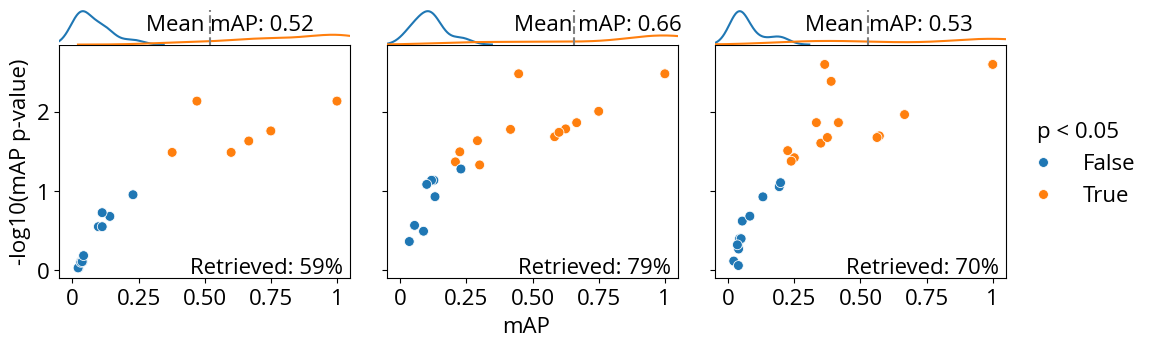

In [42]:
plot_map_x3(results, "cell_type", "", move_legend="lower right", aspect=0.3, adjust={"right": 0.85},
            pr_x=0.45, pr_y=0.02, l_x=0.91, l_y=0.65, m_x=0.45, m_y=0.085)

In [43]:
results.to_csv("../../1.calculate-metrics/cell-health/results/cell_health_gene_map.tsv", sep="\t", index=False)

In [44]:
raise

RuntimeError: No active exception to reraise

# OLD CODE (do not use)

#### batch

In [ ]:
ch_mad_df.query("Metadata_cell_line == 'A549' and Metadata_pert_name != 'EMPTY' and Metadata_pert_name not in @control_barcodes['cutting_control']").groupby(["Metadata_Plate"])["Metadata_pert_name"].value_counts().value_counts()

count
2    300
8     24
Name: count, dtype: int64

In [ ]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_pert_name"], "any": []},
    "pos_diffby": {"all": ["Metadata_Plate"], "any": []},
    "neg_sameby": {"all": ["Metadata_Plate"], "any": []},
    "neg_diffby": {"all": ["Metadata_pert_name"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_pert_name"],
    },
}

In [ ]:
meta_features = ch_df.filter(regex="Metadata_").columns.tolist()
features = ch_df.filter(regex="^(?!Metadata)").columns.tolist()

map_results = []

for cell_line in ch_df.Metadata_cell_line.unique():

    subset_df = ch_df.query("Metadata_cell_line == @cell_line").copy().reset_index(
        drop=True
    )
    
    results = evaluate_metrics(
        profiles=subset_df.reset_index(drop=True),
        features=features,
        meta_features=subset_df.filter(regex="Metadata_").columns,
        replicate_groups=pair_config,
        metrics_config=map_config,
        use_copairs=True,
    )

    map_result = results["mean_ap"]
    map_result = map_result.assign(
        cell_line=cell_line
    )
    map_results.append(map_result)

map_results = pd.concat(map_results).reset_index(drop=True)
map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
map_results["p < 0.05"] = map_results["p_value"] < 0.05
map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)
print(map_results.shape)


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]

(357, 8)


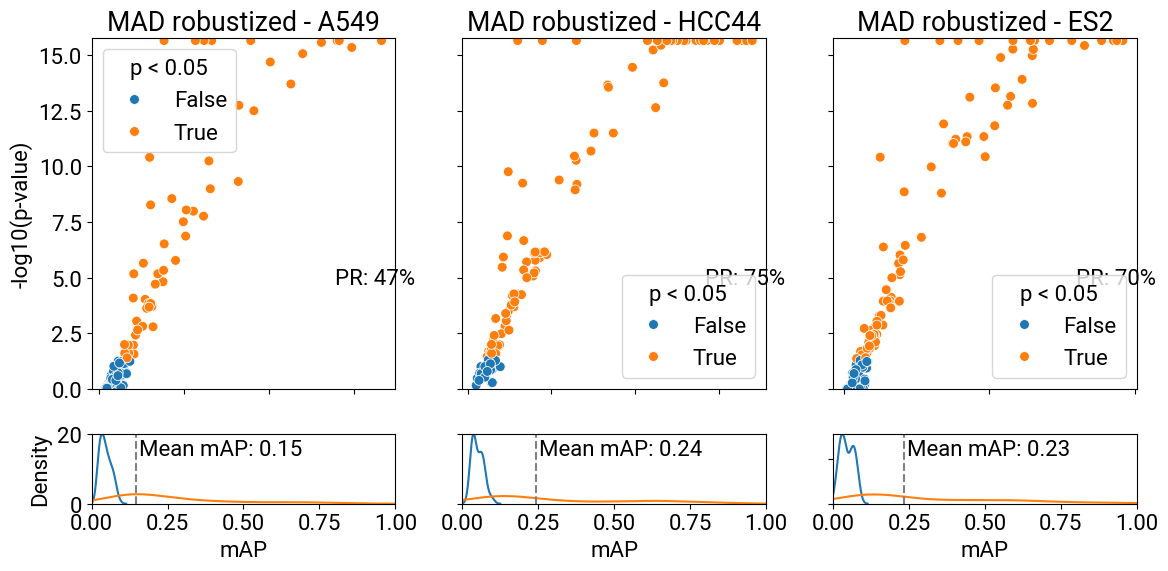

In [ ]:
plot_map_x3(map_results, "cell_line", "MAD robustized")

In [ ]:
# for cell_line in ch_df.Metadata_cell_line.unique():
#     plot_map(map_results.query("cell_line == @cell_line"), cell_line)

In [ ]:
# map_results = []

# for cell_line in ch_sph_df.Metadata_cell_line.unique():

#     subset_df = ch_sph_df.query("Metadata_cell_line == @cell_line").copy().reset_index(
#         drop=True
#     )
    
#     results = evaluate_metrics(
#         profiles=subset_df.reset_index(drop=True),
#         features=features,
#         meta_features=subset_df.filter(regex="Metadata_").columns,
#         replicate_groups=pair_config,
#         metrics_config=map_config,
#         use_copairs=True,
#     )

#     map_result = results["mean_ap"]
#     map_result = map_result.assign(
#         cell_line=cell_line
#     )
#     map_results.append(map_result)

# map_results = pd.concat(map_results).reset_index(drop=True)
# map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
# map_results["p < 0.05"] = map_results["p_value"] < 0.05
# map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)
# print(map_results.shape)

In [ ]:
# for cell_line in ch_df.Metadata_cell_line.unique():
#     plot_map(map_results.query("cell_line == @cell_line"), cell_line)

In [ ]:
meta_features = ch_nonorm_df.filter(regex="Metadata_").columns.tolist()
features = ch_nonorm_df.filter(regex="^(?!Metadata)").columns.tolist()

map_results = []

for cell_line in ch_nonorm_df.Metadata_cell_line.unique():

    subset_df = ch_nonorm_df.query("Metadata_cell_line == @cell_line").copy().reset_index(
        drop=True
    )
    
    results = evaluate_metrics(
        profiles=subset_df.reset_index(drop=True),
        features=features,
        meta_features=subset_df.filter(regex="Metadata_").columns,
        replicate_groups=pair_config,
        metrics_config=map_config,
        use_copairs=True,
    )

    map_result = results["mean_ap"]
    map_result = map_result.assign(
        cell_line=cell_line
    )
    map_results.append(map_result)

map_results = pd.concat(map_results).reset_index(drop=True)
map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
map_results["p < 0.05"] = map_results["p_value"] < 0.05
map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)
print(map_results.shape)


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]

(357, 8)


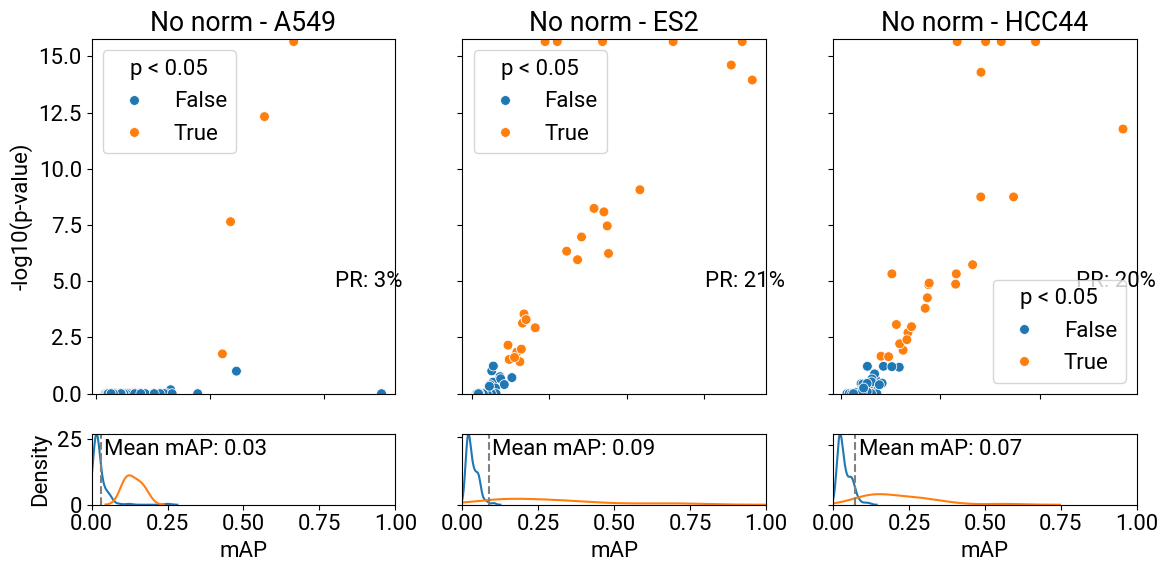

In [ ]:
plot_map_x3(map_results, "cell_line", "No norm")

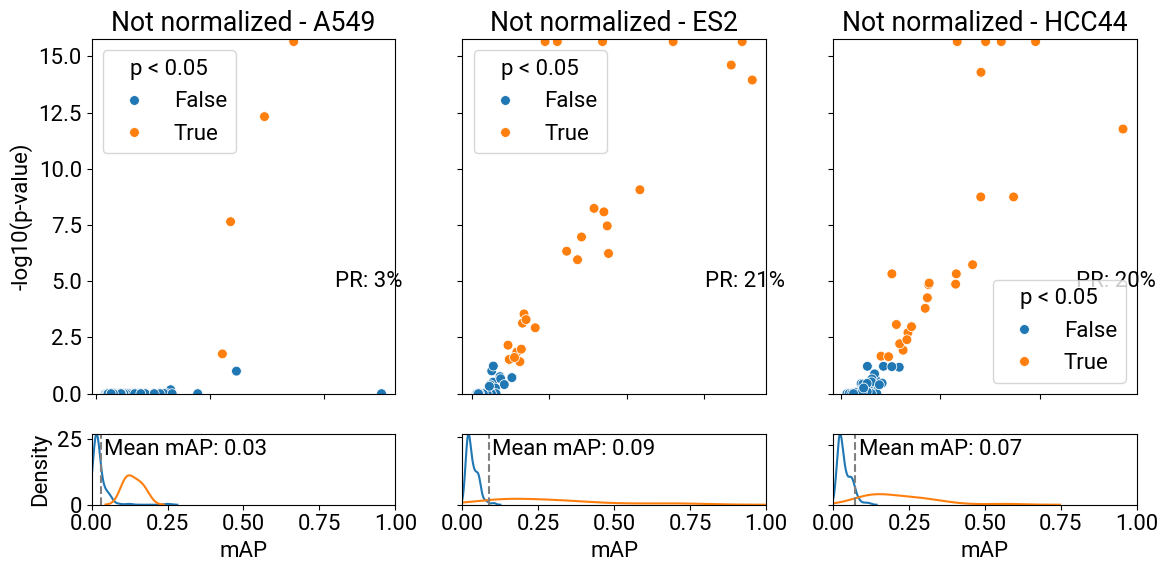

In [ ]:
plot_map(map_results, "cell_line", "Not normalized")

In [ ]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_gene_name"], "any": []},
    "pos_diffby": {"all": ["Metadata_Plate"], "any": []},
    "neg_sameby": {"all": ["Metadata_Plate"], "any": []},
    "neg_diffby": {"all": [], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_gene_name"],
    },
}

In [ ]:
# ch_df_noctrl = ch_df.query("Metadata_pert_name != 'EMPTY' and Metadata_pert_name not in @control_barcodes_cut")
ch_df_noctrl = ch_df.query("Metadata_pert_name != 'EMPTY'")
ch_df_noctrl

,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_SumAverage_DNA_20_0,Nuclei_Texture_SumAverage_ER_20_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0
1,SQ00014612,A02,2,A,A549,MCL1,MCL1-5,0.739037,-0.466950,2.245620,...,-2.527320,2.099596,0.387399,1.606377,0.619004,-1.123289,1.319333,1.126989,1.149692,0.538925
2,SQ00014612,A03,3,A,A549,AKT1,AKT1-1,0.663179,-0.614422,1.552016,...,-0.861919,1.447807,0.372708,1.232601,0.744217,0.065222,1.338340,2.086322,1.824093,0.076692
3,SQ00014612,A04,4,A,A549,KRAS,KRAS-2B,1.142720,-1.444163,2.473148,...,-1.710899,2.102723,1.144608,2.397073,1.158156,-1.639257,1.082772,0.468119,0.520477,-0.689098
4,SQ00014612,A05,5,A,A549,AKT1,AKT1-2,0.506535,-0.384485,2.334123,...,-1.934975,1.380920,-0.091729,1.584126,0.110702,-0.332856,0.630777,1.554514,1.547912,0.029147
6,SQ00014612,A07,7,A,A549,BRAF1,BRAF1-1,0.227811,0.103333,1.002592,...,-1.114289,-0.320628,-1.072588,-0.521099,-0.880352,-0.547010,0.124271,-0.837735,-0.832997,0.211909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,SQ00014613,P19,19,P,ES2,PSMA1,PSMA1-2,2.017148,-1.650721,-2.011230,...,-3.522373,1.650321,0.620966,1.060815,1.489978,1.920534,1.365998,2.359829,2.161851,1.794964
3451,SQ00014613,P20,20,P,ES2,Chr2,Chr2-4,-0.682856,1.065890,0.249829,...,1.426622,-1.377794,-1.181549,-0.949335,-1.054564,0.215409,0.147263,0.291476,-0.281496,1.065962
3453,SQ00014613,P22,22,P,ES2,POLR2D,POLR2D-2,0.825134,-1.343931,-1.244786,...,0.586443,0.112912,-1.565975,-0.367032,-1.076886,-0.862479,-0.640960,-0.096550,0.307688,-0.079216
3454,SQ00014613,P23,23,P,ES2,PPIB,PPIB-2,-0.026582,0.409760,-1.885286,...,0.520229,-2.690358,-1.749121,-1.007546,-1.702999,1.137241,1.008825,-0.914257,-1.062819,2.591231


In [ ]:
ch_df_noctrl.groupby(["Metadata_gene_name", "Metadata_Plate"]).count()

Metadata_Well  Metadata_WellCol  \
Metadata_gene_name Metadata_Plate                                    
AKT1               SQ00014610                  4                 4   
                   SQ00014611                  4                 4   
                   SQ00014612                  4                 4   
                   SQ00014613                  4                 4   
                   SQ00014614                  4                 4   
...                                          ...               ...   
YAP1               SQ00014614                  4                 4   
                   SQ00014615                  4                 4   
                   SQ00014616                  4                 4   
                   SQ00014617                  4                 4   
                   SQ00014618                  4                 4   

                                   Metadata_WellRow  Metadata_cell_line  \
Metadata_gene_name Metadata_Plate                                         
AKT1               SQ00014610                     4                   4   
                   SQ00014611                     4                   4   
                   SQ00014612                     4                   4   
                   SQ00014613                     4                   4   
                   SQ00014614                     4                   4   
...                                             ...                 ...   
YAP1               SQ00014614                     4                   4   
                   SQ00014615                     4                   4   
                   SQ00014616                     4                   4   
                   SQ00014617                     4                   4   
                   SQ00014618                     4                   4   

                                   Metadata_pert_name  \
Metadata_gene_name Metadata_Plate                       
AKT1               SQ00014610                       4   
                   SQ00014611                       4   
                   SQ00014612                       4   
                   SQ00014613                       4   
                   SQ00014614                       4   
...                                               ...   
YAP1               SQ00014614                       4   
                   SQ00014615                       4   
                   SQ00014616                       4   
                   SQ00014617                       4   
                   SQ00014618                       4   

                                   Cells_AreaShape_Compactness  \
Metadata_gene_name Metadata_Plate                                
AKT1               SQ00014610                                4   
                   SQ00014611                                4   
                   SQ00014612                                4   
                   SQ00014613                                4   
                   SQ00014614                                4   
...                                                        ...   
YAP1               SQ00014614                                4   
                   SQ00014615                                4   
                   SQ00014616                                4   
                   SQ00014617                                4   
                   SQ00014618                                4   

                                   Cells_AreaShape_Extent  \
Metadata_gene_name Metadata_Plate                           
AKT1               SQ00014610                           4   
                   SQ00014611                           4   
                   SQ00014612                           4   
                   SQ00014613                           4   
                   SQ00014614                           4   
...                                                   ...   
YAP1               SQ00014614                           4  


Calculating distances.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]

(58, 7)


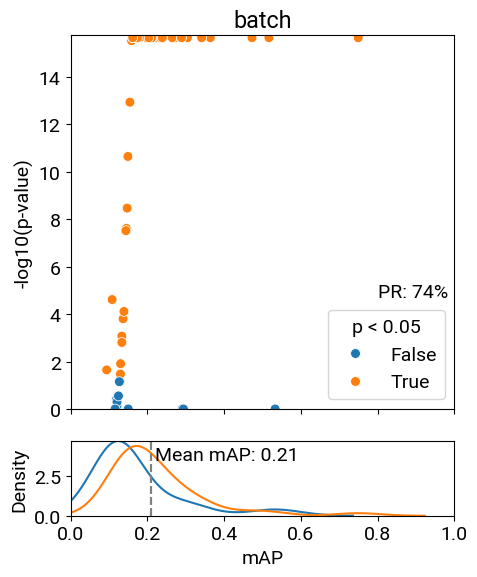


Calculating distances.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/4 [00:00<?, ?it/s]

(55, 7)


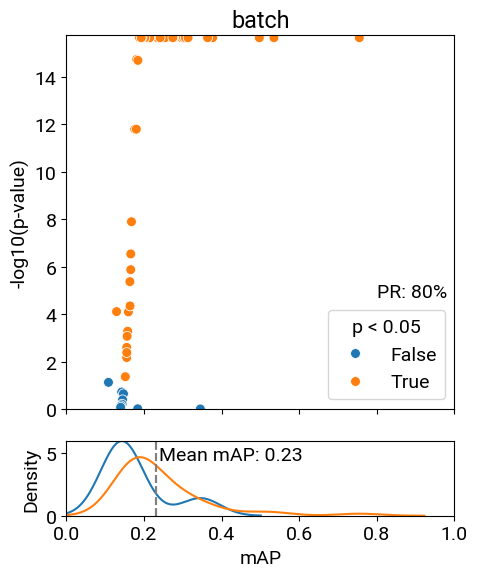


Calculating distances.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/6 [00:00<?, ?it/s]

(58, 7)


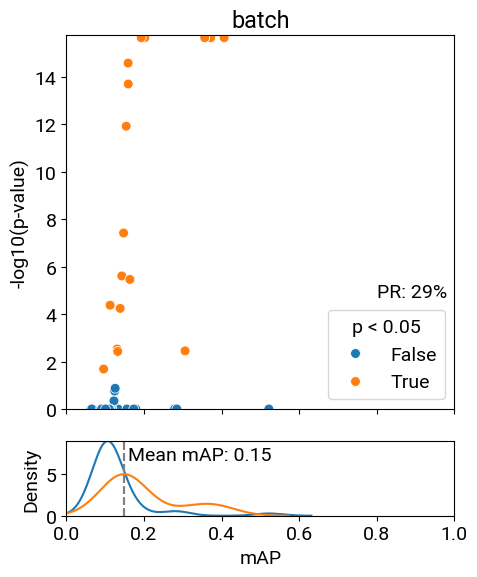


Calculating distances.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/4 [00:00<?, ?it/s]

(55, 7)


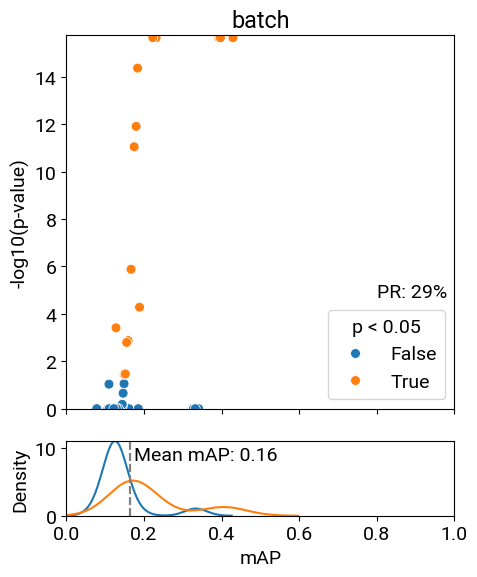

In [ ]:
datum = [
    ch_df.query("Metadata_pert_name != 'EMPTY'"),
    ch_df.query("Metadata_pert_name != 'EMPTY' and Metadata_pert_name not in @control_barcodes_cut"),
    ch_sph_df.query("Metadata_pert_name != 'EMPTY'"),
    ch_sph_df.query("Metadata_pert_name != 'EMPTY' and Metadata_pert_name not in @control_barcodes_cut"),
]

for df in datum:

    map_results = []
    results = evaluate_metrics(
        profiles=df.reset_index(drop=True),
        features=features,
        meta_features=df.filter(regex="Metadata_").columns,
        replicate_groups=pair_config,
        metrics_config=map_config,
        use_copairs=True,
    )

    map_result = results["mean_ap"]

    map_results.append(map_result)

    map_results = pd.concat(map_results).reset_index(drop=True)

    map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
    map_results["p < 0.05"] = map_results["p_value"] < 0.05
    map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)

    print(map_results.shape)
    plot_map(map_results, "batch")


#### retrieve gene from same plate vs other plates (lower is better)

In [ ]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_gene_name", "Metadata_Plate"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": ["Metadata_gene_name", "Metadata_cell_line"], "any": []},
    "neg_diffby": {"all": ["Metadata_Plate"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_gene_name"],
    },
}

In [ ]:
map_results = []

df_noctrl = ch_df.query("Metadata_pert_name != 'EMPTY' and Metadata_pert_name not in @control_barcodes_cut")

for cell_line in df_noctrl.Metadata_cell_line.unique():

    subset_df = df_noctrl.query("Metadata_cell_line == @cell_line").copy().reset_index(
        drop=True
    )

    results = evaluate_metrics(
        profiles=subset_df,
        features=features,
        meta_features=subset_df.filter(regex="Metadata_").columns,
        replicate_groups=pair_config,
        metrics_config=map_config,
        use_copairs=True,
    )

    map_result = results["mean_ap"]
    
    map_result = map_result.assign(
        cell_line=cell_line
    )

    map_results.append(map_result)

map_results = pd.concat(map_results).reset_index(drop=True)

map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
map_results["p < 0.05"] = map_results["p_value"] < 0.05
map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)

print(map_results.shape)




Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/4 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/4 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/4 [00:00<?, ?it/s]

(165, 8)


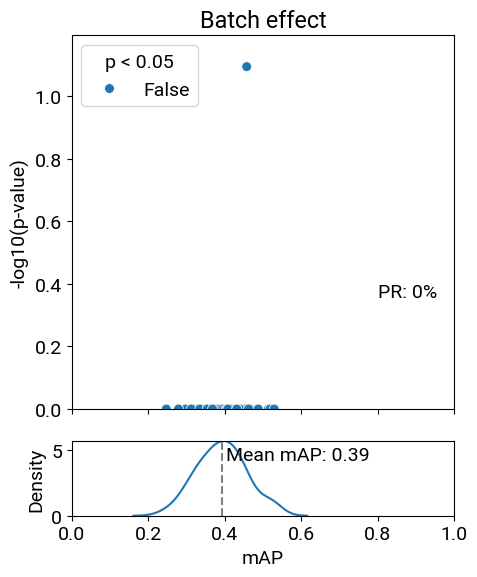

/tmp/ipykernel_54746/3971595199.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(


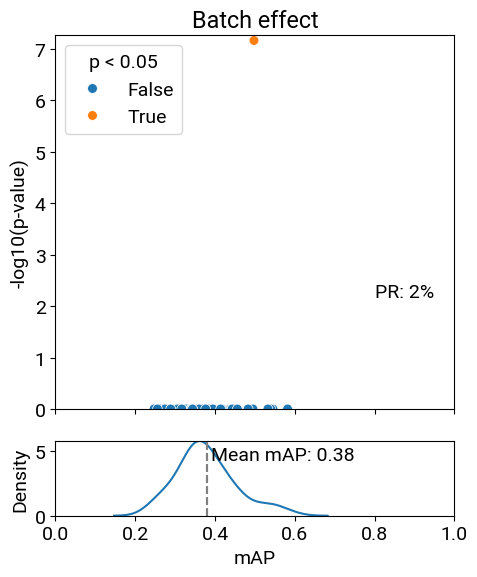

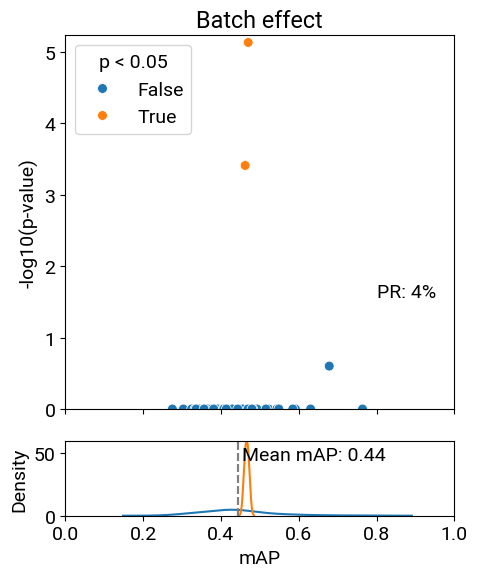

In [ ]:
for cell_line in df_noctrl.Metadata_cell_line.unique():

    df = map_results.query("cell_line == @cell_line")

    fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

    mean_map = df['mAP'].mean()
    fr = df['p < 0.05'].mean()
    sns.scatterplot(
        ax=axes[0], 
        data=df, 
        x='mAP', 
        y='-log10(p-value)', 
        hue='p < 0.05',
        s=50
    )
    axes[0].set_title(f"Batch effect")
    axes[0].text(0.8, 0.3, f"PR: {fr:.0%}", transform=axes[0].transAxes)

    axes[0].set_xlabel("")
    axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
    sns.move_legend(axes[0], "upper left")

    # Second Row: KDE plots
    max_kde_y = 0
    mean_map = df['mAP'].mean()
    for p_value in sorted(df['p < 0.05'].unique()):
        ax = sns.kdeplot(
            ax=axes[1],
            data=df[df['p < 0.05'] == p_value],
            x='mAP', 
            label=str(p_value)
        )
        max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
        axes[1].axvline(mean_map, color='grey', linestyle='--')
    # axes[1].set_ylabel("")
    axes[1].set_ylim(0, max_kde_y)
    axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

    for ax in axes.flat:
        ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

    remove_inner_ticklabels(fig)
    plt.tight_layout()
    plt.show()

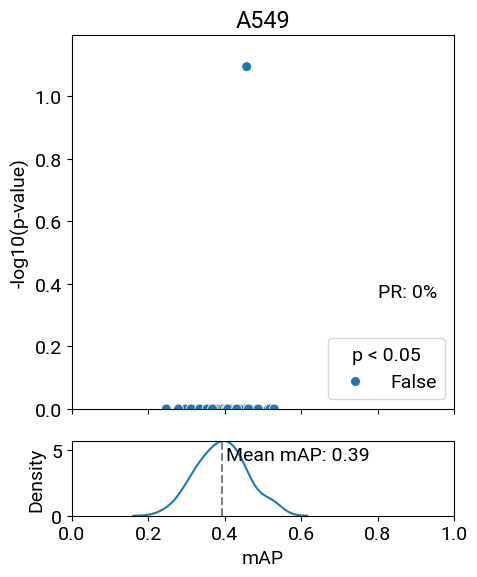

/tmp/ipykernel_27366/3052065126.py:40: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(


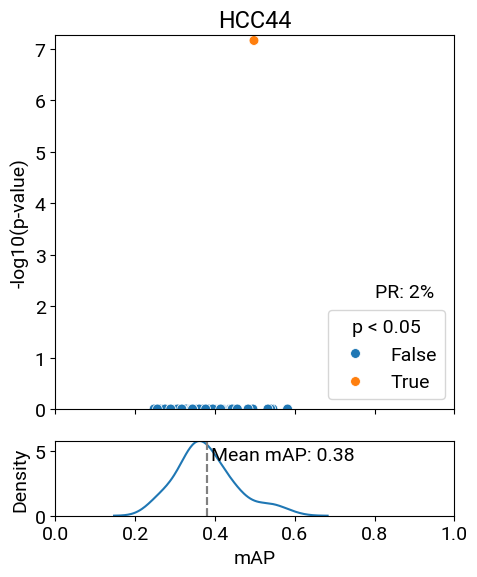

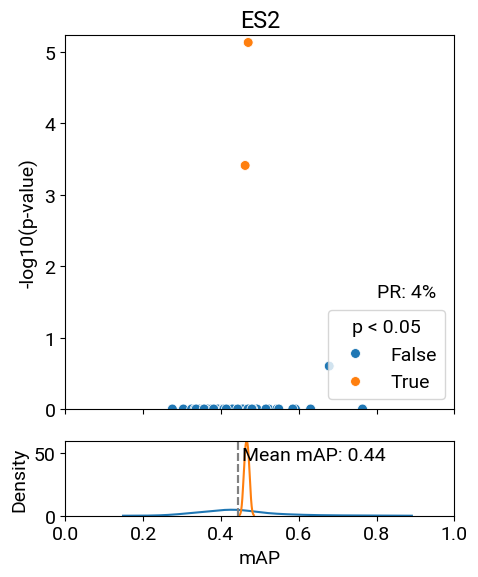

In [ ]:
for cell_line in ch_df.Metadata_cell_line.unique():
    plot_map(map_results.query("cell_line == @cell_line"), f"{cell_line}")

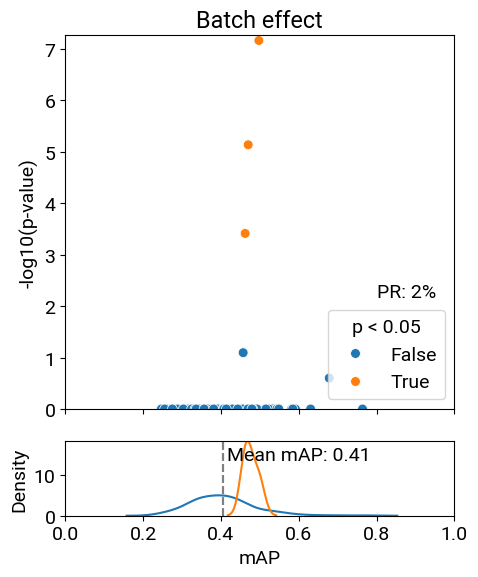

In [ ]:
df = map_results

fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['p < 0.05'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(p-value)', 
    hue='p < 0.05',
    s=50
)
axes[0].set_title(f"Batch effect")
axes[0].text(0.8, 0.3, f"PR: {fr:.0%}", transform=axes[0].transAxes)

axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
sns.move_legend(axes[0], "lower right")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in sorted(df['p < 0.05'].unique()):
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['p < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()

#### retrieve genes in different wellcols vs same well cols (higher is better)

In [ ]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_gene_name"], "any": []},
    "pos_diffby": {"all": ["Metadata_WellCol"], "any": []},
    "neg_sameby": {"all": ["Metadata_WellCol"], "any": []},
    "neg_diffby": {"all": [], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_gene_name"],
    },
}

In [ ]:
%%time
map_results = []
results = evaluate_metrics(
    profiles=df_noctrl.reset_index(drop=True),
    features=features,
    meta_features=df_noctrl.filter(regex="Metadata_").columns,
    replicate_groups=pair_config,
    metrics_config=map_config,
    use_copairs=True,
)

map_result = results["mean_ap"]

map_results.append(map_result)

map_results = pd.concat(map_results).reset_index(drop=True)

map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
map_results["p < 0.05"] = map_results["p_value"] < 0.05
map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)

print(map_results.shape)
map_results


Calculating distances.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/21 [00:00<?, ?it/s]

(55, 7)
CPU times: user 3.02 s, sys: 1.36 s, total: 4.39 s
Wall time: 2.15 s


,Metadata_gene_name,mAP,p_value,n_pos_pairs,n_total_pairs,-log10(p-value),p < 0.05
0,AKT1,0.251110,1.000000e+00,27.0,120.50,-0.000000,False
1,ARID1B,0.227036,1.000000e+00,27.0,125.00,-0.000000,False
2,ATF4,0.325979,7.149837e-23,27.0,143.00,15.653560,True
3,ATP50,0.284766,1.732432e-01,27.0,125.00,0.761344,False
4,AURKB,0.148937,1.000000e+00,9.0,107.00,-0.000000,False
5,BCL2,0.181479,1.000000e+00,27.0,129.50,-0.000000,False
6,BCL2L2,0.334039,1.000000e+00,45.0,140.00,-0.000000,False
7,BRAF,0.220226,1.108466e-06,9.0,125.00,5.955278,True
8,BRAF1,0.175480,7.947947e-02,9.0,116.00,1.099745,False
9,BRCA1,0.246722,1.000000e+00,27.0,125.00,-0.000000,False


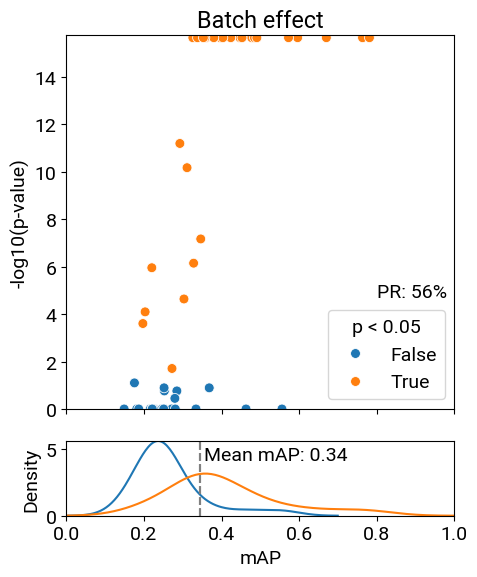

In [ ]:
df = map_results

fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['p < 0.05'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(p-value)', 
    hue='p < 0.05',
    s=50
)
axes[0].set_title(f"Batch effect")
axes[0].text(0.8, 0.3, f"PR: {fr:.0%}", transform=axes[0].transAxes)

axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
sns.move_legend(axes[0], "lower right")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in sorted(df['p < 0.05'].unique()):
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['p < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()

In [ ]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_gene_name"], "any": []},
    "pos_diffby": {"all": ["Metadata_WellRow"], "any": []},
    "neg_sameby": {"all": ["Metadata_WellRow"], "any": []},
    "neg_diffby": {"all": [], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_gene_name"],
    },
}

In [ ]:
%%time
map_results = []
results = evaluate_metrics(
    profiles=df_noctrl.reset_index(drop=True),
    features=features,
    meta_features=df_noctrl.filter(regex="Metadata_").columns,
    replicate_groups=pair_config,
    metrics_config=map_config,
    use_copairs=True,
)

map_result = results["mean_ap"]

map_results.append(map_result)

map_results = pd.concat(map_results).reset_index(drop=True)

map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
map_results["p < 0.05"] = map_results["p_value"] < 0.05
map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)

print(map_results.shape)
map_results


Calculating distances.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


Calculating metric: mean_ap


  0%|          | 0/19 [00:00<?, ?it/s]

(55, 7)
CPU times: user 3.9 s, sys: 1.87 s, total: 5.76 s
Wall time: 2.35 s


,Metadata_gene_name,mAP,p_value,n_pos_pairs,n_total_pairs,-log10(p-value),p < 0.05
0,AKT1,0.087090,1.000000e+00,18.0,206.0,-0.000000,False
1,ARID1B,0.095845,1.000000e+00,18.0,206.0,-0.000000,False
2,ATF4,0.181781,2.716038e-11,18.0,206.0,10.566064,True
3,ATP50,0.132298,1.000000e+00,18.0,206.0,-0.000000,False
4,AURKB,0.083062,1.000000e+00,9.0,197.0,-0.000000,False
5,BCL2,0.077436,1.000000e+00,18.0,206.0,-0.000000,False
6,BCL2L2,0.177695,1.000000e+00,39.0,245.0,-0.000000,False
7,BRAF,0.107769,2.663381e-01,9.0,197.0,0.574567,False
8,BRAF1,0.093086,1.000000e+00,9.0,197.0,-0.000000,False
9,BRCA1,0.097331,1.000000e+00,18.0,233.0,-0.000000,False


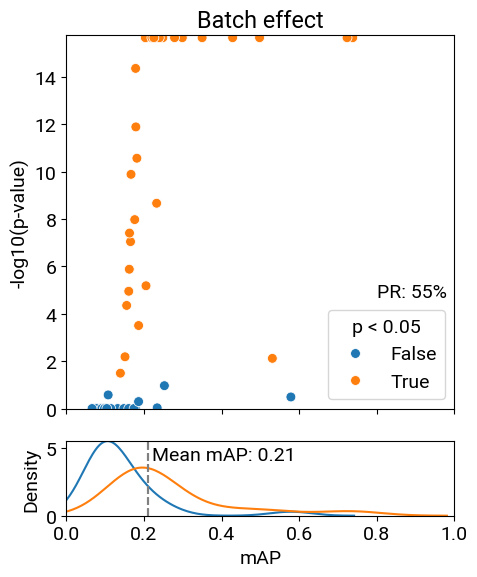

In [ ]:
df = map_results

fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['p < 0.05'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(p-value)', 
    hue='p < 0.05',
    s=50
)
axes[0].set_title(f"Batch effect")
axes[0].text(0.8, 0.3, f"PR: {fr:.0%}", transform=axes[0].transAxes)

axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
sns.move_legend(axes[0], "lower right")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in sorted(df['p < 0.05'].unique()):
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['p < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()

### replicate retrieval

In [ ]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_pert_name", "Metadata_is_control == 0"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Metadata_is_control"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_pert_name"],
    },
}

In [ ]:
%%time
map_results = []

for cell_line in ch_df.Metadata_cell_line.unique():
    for control_barcode in control_barcodes:

        other_controls = [
            ctrl for ctrl_type, ctrls in control_barcodes.items() if ctrl_type != control_barcode for ctrl in ctrls
        ]
        subset_df = ch_df.query("Metadata_cell_line == @cell_line and Metadata_pert_name not in @other_controls").copy().reset_index(
            drop=True
        )
        subset_df["Metadata_is_control"] = subset_df.Metadata_pert_name.isin(
            control_barcodes[control_barcode]
        ).astype(int)

        results = evaluate_metrics(
            profiles=subset_df,
            features=features,
            meta_features=subset_df.filter(regex="Metadata_").columns,
            replicate_groups=pair_config,
            metrics_config=map_config,
            use_copairs=True,
        )

        map_result = results["mean_ap"]
        
        map_result = map_result.assign(
            cell_line=cell_line,
            control_barcode=control_barcode
        )

        map_results.append(map_result)

map_results = pd.concat(map_results).reset_index(drop=True)
map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
map_results["p < 0.05"] = map_results["p_value"] < 0.05
map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)
print(map_results.shape)


Calculating distances.
Pos pairs size: 3708, Neg pairs size: 152064


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 3708, Neg pairs size: 133056


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 3708, Neg pairs size: 152064


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 3708, Neg pairs size: 133056


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 3708, Neg pairs size: 152064


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 3708, Neg pairs size: 133056


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]

(648, 9)
CPU times: user 18.6 s, sys: 6.55 s, total: 25.1 s
Wall time: 13.1 s


In [ ]:
map_results

,Metadata_pert_name,mAP,p_value,n_pos_pairs,n_total_pairs,cell_line,control_barcode,-log10(p-value),p < 0.05
0,AKT1-1,0.091117,3.385998e-01,5.0,197.0,A549,cutting_control,0.470313,False
1,AKT1-2,0.077613,3.385998e-01,5.0,197.0,A549,cutting_control,0.470313,False
2,ARID1B-1,0.074170,3.385998e-01,5.0,197.0,A549,cutting_control,0.470313,False
3,ARID1B-2,0.065496,6.194450e-01,5.0,197.0,A549,cutting_control,0.207997,False
4,ATF4-1,0.658049,1.002855e-15,5.0,197.0,A549,cutting_control,14.998762,True
...,...,...,...,...,...,...,...,...,...
643,TXN-2,0.105266,2.038079e-01,5.0,173.0,ES2,perturbation_control,0.690779,False
644,XBP-1,0.172551,3.958094e-03,5.0,173.0,ES2,perturbation_control,2.402514,True
645,XBP-2,0.305463,1.701880e-07,5.0,173.0,ES2,perturbation_control,6.769071,True
646,YAP1-1,0.491175,1.158855e-12,5.0,173.0,ES2,perturbation_control,11.935971,True


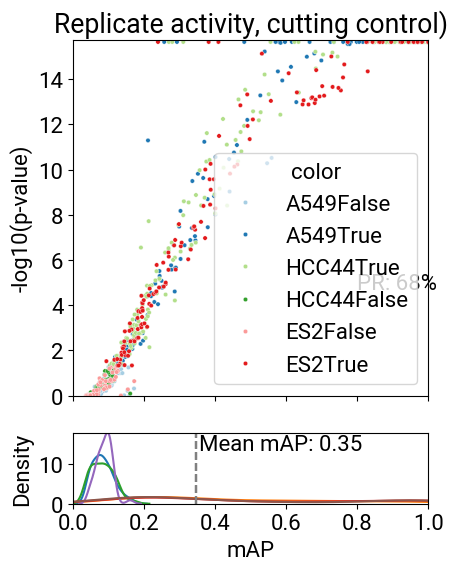

In [ ]:
df = map_results
control_barcode = "cutting_control"

fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['p < 0.05'].mean()

df["color"] = df['cell_line'] + df['p < 0.05'].astype(str)

with sns.color_palette("Paired"):

    sns.scatterplot(
        ax=axes[0], 
        data=df, 
        x='mAP', 
        y='-log10(p-value)', 
        hue='color',
        s=10
    )
    axes[0].set_title(f"Replicate activity, {control_barcode.split('_')[0]} control)")
    axes[0].text(0.8, 0.3, f"PR: {fr:.0%}", transform=axes[0].transAxes)

    axes[0].set_xlabel("")
    axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
    sns.move_legend(axes[0], "lower right")

    # Second Row: KDE plots
    max_kde_y = 0
    mean_map = df['mAP'].mean()
    for p_value in sorted(df['color'].unique()):
        ax = sns.kdeplot(
            ax=axes[1],
            data=df[df['color'] == p_value],
            x='mAP', 
            label=str(p_value)
        )
        max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
        axes[1].axvline(mean_map, color='grey', linestyle='--')
    # axes[1].set_ylabel("")
    axes[1].set_ylim(0, max_kde_y)
    axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

    for ax in axes.flat:
        ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

    remove_inner_ticklabels(fig)
    plt.tight_layout()
    plt.show()

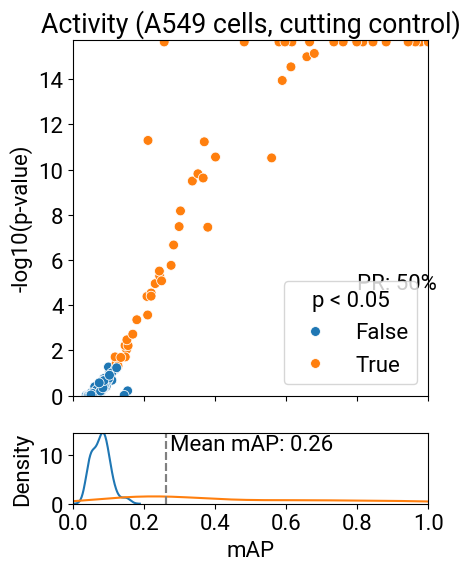

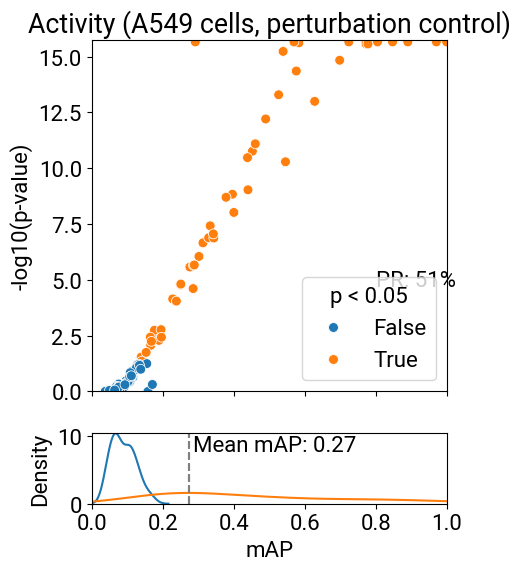

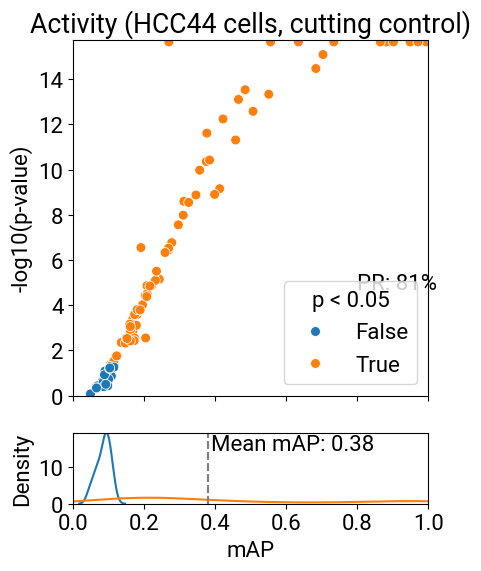

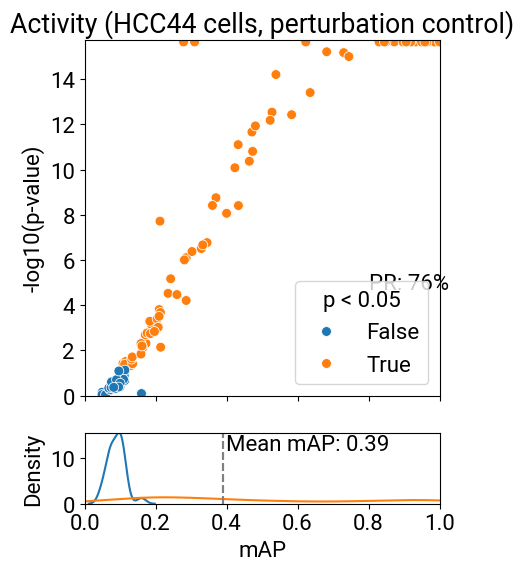

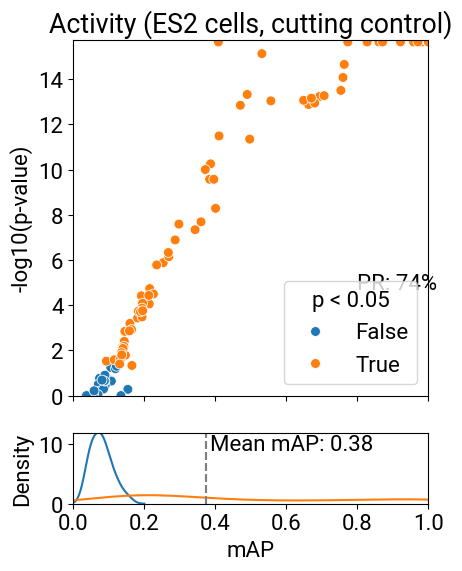

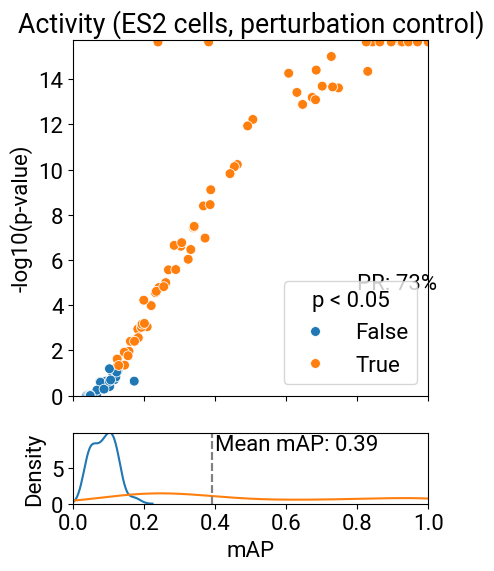

In [ ]:
for cell_line in map_results.cell_line.unique():
    for control_barcode in map_results.control_barcode.unique():

        df = map_results.query("cell_line == @cell_line & control_barcode == @control_barcode")
        plot_map(df, f"Activity ({cell_line} cells, {control_barcode.split('_')[0]} control)")

        # fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

        # mean_map = df['mAP'].mean()
        # fr = df['p < 0.05'].mean()
        # sns.scatterplot(
        #     ax=axes[0], 
        #     data=df, 
        #     x='mAP', 
        #     y='-log10(p-value)', 
        #     hue='p < 0.05',
        #     s=50
        # )
        # axes[0].set_title(f"Activity ({cell_line} cells, {control_barcode.split('_')[0]} control)")
        # axes[0].text(0.8, 0.3, f"PR: {fr:.0%}", transform=axes[0].transAxes)

        # axes[0].set_xlabel("")
        # axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
        # sns.move_legend(axes[0], "lower right")

        # # Second Row: KDE plots
        # max_kde_y = 0
        # mean_map = df['mAP'].mean()
        # for p_value in sorted(df['p < 0.05'].unique()):
        #     ax = sns.kdeplot(
        #         ax=axes[1],
        #         data=df[df['p < 0.05'] == p_value],
        #         x='mAP', 
        #         label=str(p_value)
        #     )
        #     max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
        #     axes[1].axvline(mean_map, color='grey', linestyle='--')
        # # axes[1].set_ylabel("")
        # axes[1].set_ylim(0, max_kde_y)
        # axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

        # for ax in axes.flat:
        #     ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

        # remove_inner_ticklabels(fig)
        # plt.tight_layout()
        # plt.show()


In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
replicable_perts = map_results[(map_results["control_barcode"] == 'cutting_control') & (map_results["p < 0.05"] == True)].groupby("cell_line")["Metadata_pert_name"].unique()
replicable_perts

cell_line
A549     [ATF4-1, ATF4-2, ATP50-1, ATP50-2, BCL2-2, BRD...
ES2      [ARID1B-1, ATF4-1, ATF4-2, AURKB-2, BCL2L2-2, ...
HCC44    [AKT1-1, AKT1-2, ARID1B-1, ATF4-1, ATF4-2, ATP...
Name: Metadata_pert_name, dtype: object

In [ ]:
ch_df_agg = aggregate(
    ch_df.query("Metadata_pert_name != 'EMPTY' and Metadata_pert_name not in @control_barcodes_cut"),
    strata=["Metadata_pert_name", "Metadata_gene_name", "Metadata_cell_line"],
    features="infer"
)
ch_df_agg

,Metadata_pert_name,Metadata_gene_name,Metadata_cell_line,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumAverage_DNA_20_0,Nuclei_Texture_SumAverage_ER_20_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0
0,AKT1-1,AKT1,A549,0.341199,-0.229691,0.424161,0.165376,-0.033985,-0.211055,-0.055991,...,-0.009188,0.504725,0.217921,0.413354,0.452532,0.113044,0.557936,0.866277,0.541440,-0.047612
1,AKT1-1,AKT1,ES2,-0.205478,0.208953,0.509482,0.367540,0.507198,0.112112,0.349423,...,0.181501,0.253777,0.190058,0.824226,0.222666,0.435777,0.857353,0.795755,0.477671,0.239250
2,AKT1-1,AKT1,HCC44,0.100067,0.341650,0.180864,0.352184,-0.032830,-0.173660,-0.064015,...,-0.617208,-0.388100,-0.825479,-0.820233,-0.835615,-0.505573,-0.897156,-0.204028,-0.138615,-0.053818
3,AKT1-2,AKT1,A549,-0.308239,0.364688,0.385200,0.553686,0.461241,0.535217,-0.494043,...,-0.175027,-0.188977,-0.068598,0.117897,-0.060139,-0.491295,-0.094522,-0.106256,-0.018244,-0.024718
4,AKT1-2,AKT1,ES2,-0.172956,0.341642,0.603838,0.682714,0.355975,-0.206561,0.462911,...,0.844215,-0.277192,-0.357435,-0.311059,-0.355146,-0.452672,-0.433780,-0.273643,-0.301361,0.281180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,YAP1-1,YAP1,ES2,0.990687,-1.488293,-1.978445,-1.579459,-0.898555,-0.535487,-1.082154,...,-2.479445,0.228065,0.944951,1.090018,0.912951,1.555452,1.157944,1.722306,0.914203,1.093160
320,YAP1-1,YAP1,HCC44,-0.671656,1.375212,0.607208,1.280685,0.498336,-0.168915,0.587830,...,0.015447,-0.393251,0.589058,0.878791,1.204047,0.894562,0.865301,1.254463,0.980120,0.058385
321,YAP1-2,YAP1,A549,-0.486640,0.184011,0.498957,-0.432204,0.369998,0.612429,-0.249065,...,-0.370801,-0.671591,0.144719,-0.167376,0.141020,-0.306070,0.427471,-0.395535,0.048877,0.142075
322,YAP1-2,YAP1,ES2,0.871657,-1.750439,-1.576599,-1.406829,-1.065549,0.423655,-1.245855,...,-2.910420,0.845251,1.710797,1.676980,1.927458,1.565802,1.615817,2.819930,1.955103,0.584102


In [ ]:
replicable_genes = {}
for cell_type in ch_df_agg.Metadata_cell_line.unique():
    replicable_genes[cell_type] = (ch_df_agg[(ch_df_agg["Metadata_cell_line"] == cell_type) & (ch_df_agg["Metadata_pert_name"].isin(replicable_perts[cell_type]))].Metadata_gene_name.value_counts() > 1).index.tolist()

replicable_genes

{'A549': ['CDK4',
  'ATF4',
  'GLS',
  'PTK2',
  'PSMA1',
  'PPIB',
  'POLR2D',
  'PIK3CA',
  'MYC',
  'MTOR',
  'KRAS',
  'KIF11',
  'ATP50',
  'ITGAV',
  'SUZ12',
  'ERBB2',
  'EGFR',
  'CSNK1A1',
  'CCNE1',
  'CCND1',
  'BRD4',
  'SMARCB1',
  'SLC2A2',
  'SLC2A1',
  'SDHB',
  'BCL2',
  'EZH2',
  'HIF1a',
  'CTNNB1',
  'MAPK1',
  'EGLN1',
  'JAK3',
  'CDK2'],
 'ES2': ['CDK4',
  'KIF11',
  'GPX4',
  'ITGAV',
  'ATF4',
  'KRAS',
  'MAPK1',
  'MCL1',
  'MTOR',
  'MYC',
  'POLR2D',
  'PSMA1',
  'PTK2',
  'RAC1',
  'RHOA',
  'SDHB',
  'SMARCB1',
  'SUZ12',
  'XBP',
  'HIF1a',
  'YAP1',
  'ERBB2',
  'EGLN1',
  'EGFR',
  'BRD4',
  'CTNNB1',
  'CSNK1A1',
  'CCND1',
  'CCNE1',
  'EZH2',
  'CDK2',
  'GLS',
  'SLC2A2',
  'BCL2L2',
  'BRAF',
  'BRAF1',
  'TXN',
  'AURKB',
  'SLC2A1',
  'PRDX1',
  'BRCA1',
  'RAF1',
  'PPIB',
  'PIK3CA',
  'ORC4',
  'CHEK2',
  'DOT1L',
  'ARID1B'],
 'HCC44': ['CDK4',
  'AKT1',
  'PIK3CA',
  'ITGAV',
  'JAK3',
  'KIF11',
  'KRAS',
  'MTOR',
  'MYC',
  'ORC4',
  'P

In [ ]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_gene_name"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Metadata_gene_name"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Metadata_gene_name"],
    },
    # "mp_value": {
    #     "control_perts": [1],
    #     "replicate_id": f"{gene_col}",
    #     "rescale_pca": True,
    #     "nb_permutations": 1000,
    # },
}

In [ ]:
cell_line = "A549"
ch_df_agg_a549 = ch_df_agg.query("Metadata_cell_line == @cell_line and Metadata_gene_name in @replicable_genes[@cell_line]")
ch_df_agg_a549.reset_index(drop=True, inplace=True)
ch_df_agg_a549

,Metadata_pert_name,Metadata_gene_name,Metadata_cell_line,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumAverage_DNA_20_0,Nuclei_Texture_SumAverage_ER_20_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0
0,ATF4-1,ATF4,A549,-0.307816,0.313221,-0.941945,0.705606,-1.095045,0.951916,0.462500,...,0.541730,2.113891,1.464380,0.752596,0.895537,1.068926,-0.331443,0.181980,-0.187181,1.072499
1,ATF4-2,ATF4,A549,0.870495,-0.444584,-1.246034,0.376953,-2.106385,-0.263932,-0.315618,...,0.538569,2.189669,1.478663,0.769935,0.946534,0.497580,-0.179945,-0.015630,-0.065556,0.566532
2,ATP50-1,ATP50,A549,0.251456,-0.224289,0.423817,-0.247883,-0.209594,0.450757,-0.346095,...,-0.388826,0.068867,0.238602,0.454857,0.175941,-0.224808,0.628232,0.216802,0.793485,-0.096641
3,ATP50-2,ATP50,A549,-0.972380,1.679988,-1.140137,1.303751,0.493210,-0.557296,0.925679,...,0.631137,1.016549,-0.022194,-1.161310,-0.311913,0.097034,-1.179292,-0.341055,-0.543205,0.276848
4,BCL2-1,BCL2,A549,0.560437,-0.506505,0.702441,-0.384315,-0.490767,-0.199177,-0.460842,...,-0.213383,0.126164,-0.409444,-0.342051,-0.435022,-0.208018,-0.006417,-0.406820,-0.191833,0.193742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,SLC2A2-2,SLC2A2,A549,-0.091321,-0.106413,0.412805,-0.042295,0.196119,-0.070792,-0.102157,...,-0.391357,-0.636885,0.780834,-0.361997,0.475317,-0.116209,0.287742,-0.024193,0.089919,0.135960
62,SMARCB1-1,SMARCB1,A549,0.354536,-0.168091,0.486542,-0.247713,-0.310564,0.555695,-0.995854,...,0.012226,0.712765,-1.159095,0.022065,-1.115320,-1.246085,-1.114817,-0.580551,-0.735532,-0.134100
63,SMARCB1-2,SMARCB1,A549,0.219549,-0.553051,1.041780,-0.260666,0.060302,0.522072,-1.505280,...,-1.056284,0.591324,0.485961,0.379964,0.461984,-0.113306,0.354188,0.145379,0.235577,-0.322065
64,SUZ12-1,SUZ12,A549,-0.588769,0.857539,-1.777789,0.502846,0.263348,-1.631155,1.425779,...,1.453710,0.121341,0.540789,-0.208783,0.248749,0.103281,-0.560462,-0.594449,-0.624158,-0.615866


In [ ]:
# %%time
map_results = []

for cell_line in ch_df_agg.Metadata_cell_line.unique():

    subset_df = ch_df_agg.query("Metadata_cell_line == @cell_line and Metadata_gene_name in @replicable_genes[@cell_line]").copy()
    results = evaluate_metrics(
        profiles=subset_df.reset_index(drop=True),
        features=features,
        meta_features=subset_df.filter(regex="Metadata_").columns,
        replicate_groups=pair_config,
        metrics_config=map_config,
        use_copairs=True,
    )
    map_result = results["mean_ap"]
    
    map_result = map_result.assign(
        cell_line=cell_line,
    )

    map_results.append(map_result)

map_results = pd.concat(map_results).reset_index(drop=True)
map_results["-log10(p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
map_results["p < 0.05"] = map_results["p_value"] < 0.05
map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)
print(map_results.shape)



Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]


Calculating distances.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/3 [00:00<?, ?it/s]

(120, 8)


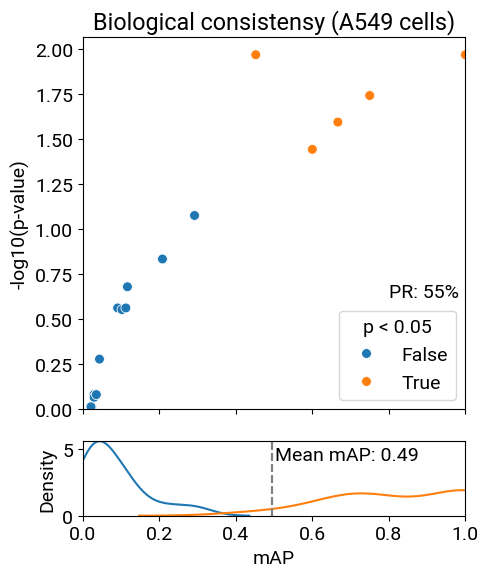

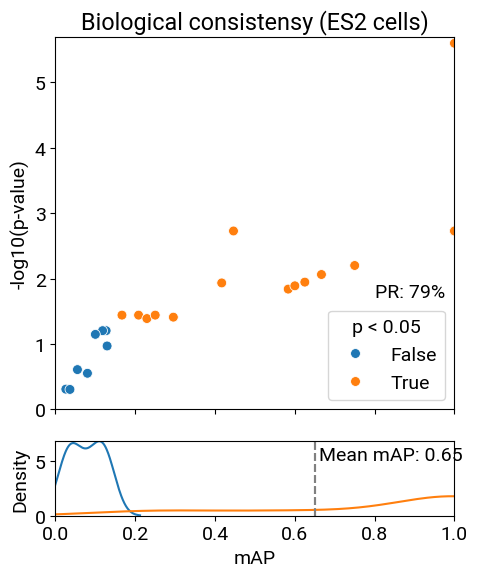

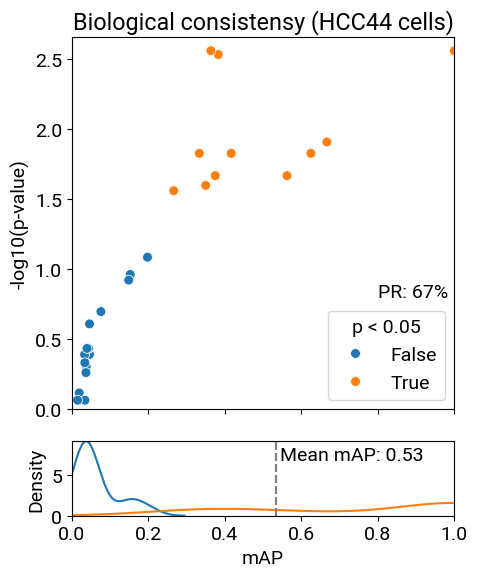

In [ ]:
for cell_line in map_results.cell_line.unique():
    df = map_results.query("cell_line == @cell_line")

    plot_map(df, f"Biological consistensy ({cell_line} cells)")

    # fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

    # mean_map = df['mAP'].mean()
    # fr = df['p < 0.05'].mean()
    # sns.scatterplot(
    #     ax=axes[0], 
    #     data=df, 
    #     x='mAP', 
    #     y='-log10(p-value)', 
    #     hue='p < 0.05',
    #     s=50
    # )
    # axes[0].set_title(f"Phenotypic consistency ({cell_line} cells)")
    # axes[0].text(0.8, 0.3, f"PR: {fr:.0%}", transform=axes[0].transAxes)

    # axes[0].set_xlabel("")
    # axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
    # sns.move_legend(axes[0], "lower right")

    # # Second Row: KDE plots
    # max_kde_y = 0
    # mean_map = df['mAP'].mean()
    # for p_value in sorted(df['p < 0.05'].unique()):
    #     ax = sns.kdeplot(
    #         ax=axes[1],
    #         data=df[df['p < 0.05'] == p_value],
    #         x='mAP', 
    #         label=str(p_value)
    #     )
    #     max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    #     axes[1].axvline(mean_map, color='grey', linestyle='--')
    # # axes[1].set_ylabel("")
    # axes[1].set_ylim(0, max_kde_y)
    # axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

    # for ax in axes.flat:
    #     ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

    # remove_inner_ticklabels(fig)
    # plt.tight_layout()
    # plt.show()


In [ ]:
# Some perturbations have only one guide per gene, these cannot have grit scores
print(map_results.mean_ap.isna().sum())
map_results.loc[map_results.mean_ap.isna(), :].reset_index(drop=True).head(5)

0


,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control


In [ ]:
map_results

,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control
0,AKT1,AKT1-1,0.236639,0.123396,11.0,203.0,HCC44,cutting_control
1,AKT1,AKT1-2,0.198102,0.148055,11.0,203.0,HCC44,cutting_control
2,ARID1B,ARID1B-1,0.122817,0.166342,11.0,203.0,HCC44,cutting_control
3,ARID1B,ARID1B-2,0.127141,0.141236,11.0,203.0,HCC44,cutting_control
4,ATF4,ATF4-1,0.315895,0.023718,11.0,203.0,HCC44,cutting_control
...,...,...,...,...,...,...,...,...
676,TXN,TXN-2,0.269523,0.051740,11.0,179.0,ES2,perturbation_control
677,XBP,XBP-1,0.359246,0.043196,11.0,179.0,ES2,perturbation_control
678,XBP,XBP-2,0.362530,0.039621,11.0,179.0,ES2,perturbation_control
679,YAP1,YAP1-1,0.745002,0.000730,11.0,179.0,ES2,perturbation_control


In [ ]:
# Output results
output_dir = "results"
output_file = pathlib.Path(f"{output_dir}/cell_health_map.tsv")

map_results.to_csv(output_file, sep="\t", index=False)

## Calculate mp-value

In [ ]:
# %%time
# mp_results = []

# for cell_line in df.Metadata_cell_line.unique():
#     for num_permutations in [10, 100, 1000, 5000]:
#         mp_value_params = {"nb_permutations": num_permutations}

#         result = evaluate(
#             profiles=df.query("Metadata_cell_line == @cell_line"),
#             features=features,
#             meta_features=[barcode_col, gene_col],
#             replicate_groups="Metadata_pert_name",
#             operation="mp_value",
#             grit_control_perts=control_barcodes["cutting_control"],
#             mp_value_params=mp_value_params,
#         ).assign(
#             cell_line=cell_line,
#             barcode_control="cutting_control",
#             num_permutations=num_permutations,
#         )

#         mp_results.append(result)

# mp_results = pd.concat(mp_results).reset_index(drop=True)

# print(mp_results.shape)
# mp_results.head()

(1428, 5)
CPU times: user 39min 42s, sys: 29min 10s, total: 1h 8min 52s
Wall time: 35min 59s


,Metadata_pert_name,mp_value,cell_line,barcode_control,num_permutations
0,AKT1-1,0.1,HCC44,cutting_control,10
1,AKT1-2,0.2,HCC44,cutting_control,10
2,ARID1B-1,0.2,HCC44,cutting_control,10
3,ARID1B-2,0.3,HCC44,cutting_control,10
4,ATF4-1,0.0,HCC44,cutting_control,10


In [ ]:
mp_value_results

,Metadata_is_control,Metadata_gene_name,clique_id,mp_value,cell_line,barcode_control
0,0,EMPTY,0,0.000999,HCC44,cutting_control
1,0,MCL1,1,0.004995,HCC44,cutting_control
2,0,AKT1,2,0.012987,HCC44,cutting_control
3,0,KRAS,3,0.000999,HCC44,cutting_control
4,0,AKT1,2,0.012987,HCC44,cutting_control
...,...,...,...,...,...,...
5827,0,PSMA1,15,0.000999,ES2,perturbation_control
5828,0,Chr2,12,0.000999,ES2,perturbation_control
5829,0,POLR2D,14,0.000999,ES2,perturbation_control
5830,0,PPIB,13,0.000999,ES2,perturbation_control


In [ ]:
# Output results
output_file = pathlib.Path(f"{output_dir}/cell_health_mpvalue.tsv")

mp_value_results.to_csv(output_file, sep="\t", index=False)